<a href="https://colab.research.google.com/github/D-Mayerfeld/intro-numerical-methods/blob/master/09_ODE_ivp_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  The presentation below largely follows part II in "Finite Difference Methods for Ordinary and Partial Differential Equations" by LeVeque (SIAM, 2007).

In [35]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt

## Explaining the concepts before Runge-Kutta Methods

Before diving into Runge-Kutta methods, let's summarize the core idea behind numerically solving Ordinary Differential Equations (ODEs) and the methods we've explored so far.

The fundamental problem we are trying to solve is an initial value problem (IVP) of the form:

$$
\frac{\text{d}\mathbf{u}}{\text{d}t} = \mathbf{f}(t, \mathbf{u}) \quad \mathbf{u}(t_0) = \mathbf{u}_0
$$

This equation describes how the state of a system, represented by the vector $\mathbf{u}$, changes over time, given its initial state $\mathbf{u}_0$. The function $\mathbf{f}(t, \mathbf{u})$ tells us the rate of change of $\mathbf{u}$ at any given time $t$ and state $\mathbf{u}$.

Instead of finding an exact analytical solution (which is often impossible for complex systems), we aim to find a numerical approximation of $\mathbf{u}(t)$ at discrete time points.

The integral form of the ODE provides a key insight:

$$
\mathbf{u}(t + \Delta t) = \mathbf{u}(t) + \int^{t + \Delta t}_t \mathbf{f}(\tau, \mathbf{u}(\tau)) d\tau
$$

This equation says that the state of the system at a future time $t + \Delta t$ is equal to its current state $\mathbf{u}(t)$ plus the accumulated change over the time interval $\Delta t$. This accumulated change is represented by the integral of the rate of change function $\mathbf{f}$ along the true solution path $\mathbf{u}(\tau)$ from $t$ to $t + \Delta t$.

The challenge is that we don't know the true solution $\mathbf{u}(\tau)$ within the integral. Numerical methods approximate this integral using different strategies.

### The Geometric Picture: Following the Slope

Imagine the function $\mathbf{f}(t, \mathbf{u})$ as defining a "slope field" or "direction field" at every point $(t, \mathbf{u})$. The true solution $\mathbf{u}(t)$ is a curve that follows these slopes. Numerical methods essentially try to "walk" along this slope field to approximate the true solution.

Here's a visual representation of this idea:

<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-554206514.py:23: SyntaxWarning: invalid escape sequence '\D'
  axes.text(900., uK - .1, '$\Delta t$', fontsize=24, color='red')
/tmp/ipython-input-554206514.py:29: SyntaxWarning: invalid escape sequence '\l'
  axes.set_title("Direction Set, $u' = - \lambda u$, $u(0)=1$", fontsize=18)


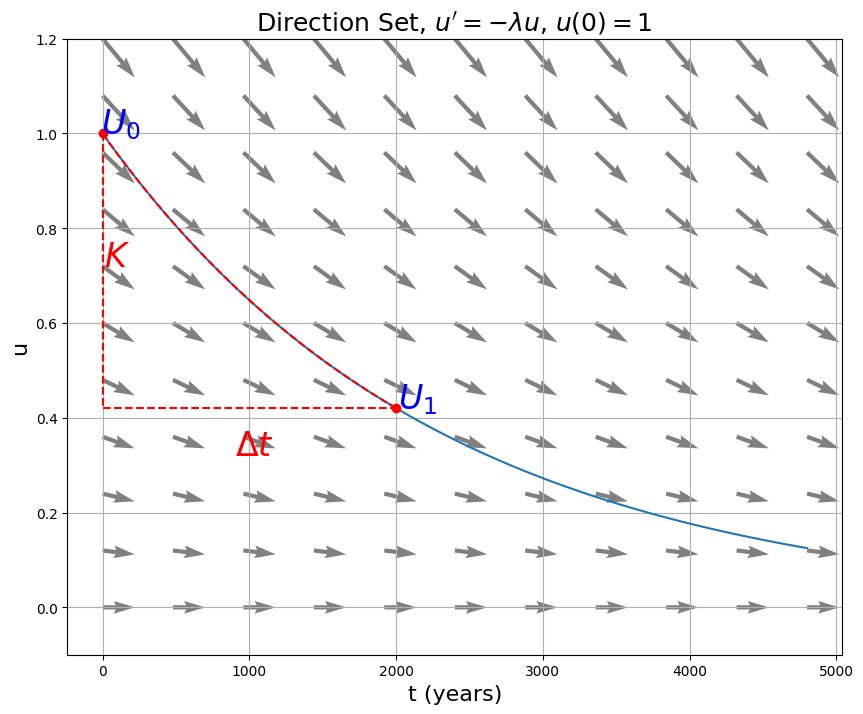

In [36]:
t = numpy.linspace(0., 4800, 11)
y = numpy.linspace(0., 1.2, 11)
T, Y = numpy.meshgrid(t,y)
dt = numpy.ones(T.shape)
dy = -dt*Y

tK = 2000.
uK = numpy.exp(decay_constant*tK)
K = uK -1.
tp = numpy.linspace(0., 4800, 100)
tk = numpy.linspace(0., tK, 100)

fig = plt.figure(figsize=(10,8))
axes = fig.add_subplot(1, 1, 1)
axes.quiver(T,Y, dt,dy, color='gray')
axes.plot(tp,numpy.exp(decay_constant*tp))
axes.plot(0.,1.,'ro')
axes.plot(tk,numpy.exp(decay_constant*tk),'r--')
axes.plot(tK, uK, 'ro')
axes.plot([0.,0.], [1., uK], 'r--')
axes.text(10., 0.72, '$K$', fontsize=24, color='red')
axes.plot([0.,tK],[uK, uK], 'r--')
axes.text(900., uK - .1, '$\Delta t$', fontsize=24, color='red')
axes.text(-10, 1., '$U_0$', fontsize=24, color='blue')
axes.text(tK+10, uK, '$U_1$', fontsize=24, color='blue')


axes.grid()
axes.set_title("Direction Set, $u' = - \lambda u$, $u(0)=1$", fontsize=18)
axes.set_xlabel('t (years)', fontsize=16)
axes.set_ylabel('u', fontsize=16)

axes.set_ylim((-.1,1.2))
plt.show()

### Approaches to Approximating the Integral

The different numerical methods vary in how they approximate the integral $\int^{t + \Delta t}_t \mathbf{f}(\tau, \mathbf{u}(\tau)) d\tau$. This is where the concept of "quadrature" comes in, which is the numerical approximation of integrals.

**1. Forward Euler Method (1-stage, Explicit)**

*   **Math:**
    $$
    U_{n+1} = U_n + \Delta t f(t_n, U_n)
    $$
*   **Explanation:** This is the simplest method. It approximates the integral by assuming the rate of change $\mathbf{f}$ is constant over the interval $\Delta t$, and equal to its value at the beginning of the interval, $(t_n, U_n)$. Geometrically, this is like using the slope at the current point to project linearly to the next point. This is analogous to the left-rectangle rule for numerical integration. It is a first-order method, meaning its error is proportional to $\Delta t$.

**2. Backward Euler Method (1-stage, Implicit)**

*   **Math:**
    $$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1})
    $$
*   **Explanation:** This method approximates the integral using the rate of change at the *end* of the interval, $(t_{n+1}, U_{n+1})$. Since $U_{n+1}$ is unknown, this leads to an implicit equation that needs to be solved for $U_{n+1}$ at each step. This is analogous to the right-rectangle rule. It is also a first-order method, but it can be more stable for certain types of problems.

**3. Trapezoidal Method (2-stage, Implicit)**

*   **Math:**
    $$
    U_{n+1} = U_{n} + \frac{\Delta t}{2} (f(t_n, U_n) + f(t_{n+1}, U_{n+1}))
    $$
*   **Explanation:** This method uses the average of the rates of change at the beginning and end of the interval to approximate the integral. This is analogous to the trapezoidal rule for numerical integration. Like Backward Euler, it's an implicit method. It is a second-order method, generally more accurate than the Euler methods for a given step size.

These methods are the foundation for understanding how we can numerically step through time to approximate the solution of an ODE. Runge-Kutta methods build upon these ideas by using more sophisticated ways to sample the function $\mathbf{f}$ within the interval $\Delta t$ to achieve higher orders of accuracy.

# Notes starts here

# Numerical Solution to ODE Initial Value Problems - Part 1

Many physical, biological, and societal systems can be written as a system of ordinary differential equations (ODEs).  In the case where the initial state (value) is know the problems can be written as

$$
    \frac{\text{d}\mathbf{u}}{\text{d}t} = \mathbf{f}(t, \mathbf{u}) \quad \mathbf{u}(0) = \mathbf{u}_0
$$

where
 - $\mathbf{\!u}(t)$ is the state vector
 - $\mathbf{\!f}(t, \mathbf{\!u})$ is a vector-valued function that describes the evolution of $\mathbf{u}$ with time
 - $\mathbf{\!u}(0)$ is the initial condition at time $t = 0$

### The Example for our time:  A non-linear  model of Epidemics

Classical [Kermack and McKendrick (1927)](https://royalsocietypublishing.org/doi/10.1098/rspa.1927.0118) SIR model of epidemics (with reinfection)

$$
\begin{align}
    \frac{ds}{dt} &= -si + kr \\
    \frac{di}{dt} &= si -\sigma i \\
    \frac{dr}{dt} &= \sigma i - kr\\
\end{align}
$$

Where the variable $s$ represents the fraction of a population that is **Susceptible** to infection, $i$ is the proportion **Infected** and $r$ the fraction **Recovered**.  For this model $s+i+r =1$.  The parameters $\sigma, k \geq 0$ control the relative rates of infection and recovery.  

For this problem
$$
\mathbf{u}(t) = \begin{bmatrix} s(t)\\ i(t)\\ r(t)\\\end{bmatrix},\quad\quad
\mathbf{f}(t,\mathbf{u}) = \begin{bmatrix} -si + kr \\ si -\sigma i \\ \sigma i - kr\\\end{bmatrix}
$$

### Numerical Solutions

In [37]:
# Solve using SciPy's ODE integrator solve_ivp
from scipy.integrate import solve_ivp

# define the RHS of our system of ODE's
def f_sir(t, u, sigma, k):
    s,i,r = u
    return numpy.array([-s*i + k*r,
                        (s - sigma)*i,
                        sigma*i - k*r ])

In [38]:
sigma = .5
k = 0.025
t_max = 100
u_0 = [0.999, 0.001, 0.]
sol = solve_ivp(f_sir, [0, t_max] , u_0, args=(sigma, k), rtol=1.e-6, atol=1.e-9,dense_output = True)

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-421130100.py:9: SyntaxWarning: invalid escape sequence '\s'
  axes.plot(t,sigma*numpy.ones(t.shape),'k--',label='$\sigma$')
/tmp/ipython-input-421130100.py:15: SyntaxWarning: invalid escape sequence '\s'
  axes.set_title('SIR system: $\sigma={}$, $k={}$'.format(sigma,k),fontsize=18)


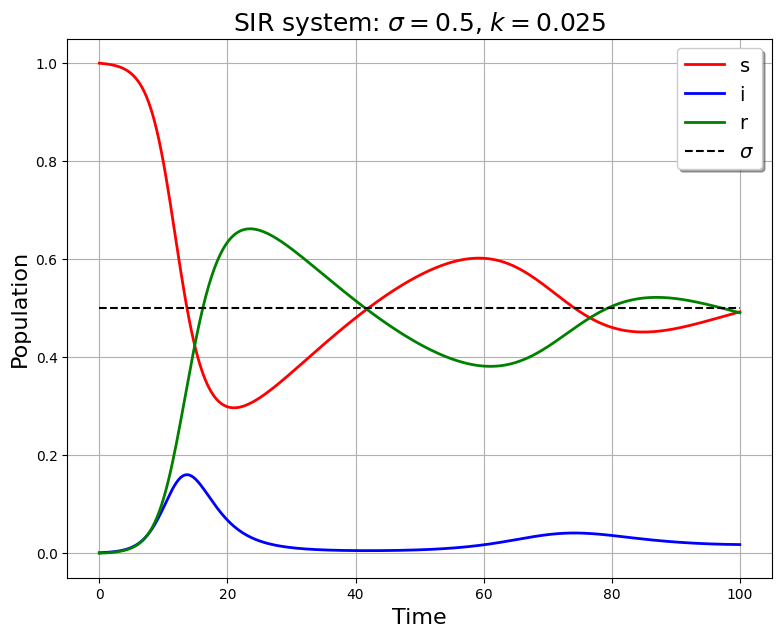

In [39]:
t = numpy.linspace(0, t_max, 300)
z = sol.sol(t)

fig = plt.figure(figsize=(20,7))
axes = fig.add_subplot(1,2,1)
axes.plot(t,z[0],'r',label='s', linewidth=2)
axes.plot(t,z[1],'b',label='i', linewidth=2)
axes.plot(t,z[2],'g',label='r',  linewidth=2)
axes.plot(t,sigma*numpy.ones(t.shape),'k--',label='$\sigma$')

axes.legend(loc='best',shadow=True, fontsize=14)
axes.set_xlabel('Time',fontsize=16)
axes.set_ylabel('Population',fontsize=16)
axes.grid()
axes.set_title('SIR system: $\sigma={}$, $k={}$'.format(sigma,k),fontsize=18)
plt.show()

### Questions an epidemiologist might ask:
 - What are the dynamics of this system?  does it predict steady or oscillatory solutions?
 - Can we estimate critical parameters ($\sigma$, $k$) from data?
 - Can we reliably use this model to predict the future?
 - How do we evaluate whether this is a *useful* model?
 - How might I modify/improve this model.



### Questions a Computational Mathematician might ask:
 - Does a solution to the model even exist and is it unique?
 - Is our approximate numerical solution accurate?
 - What are the dynamics of this system?  does it predict steady or oscillatory solutions?
 - how do we understand the sensitivity to parameters?

### Existence and Uniqueness of solutions (n-D autonomous systems)

For proof see [Hirsch, Smale, Devaney, Dynamical Systems](https://www.amazon.com/Differential-Equations-Dynamical-Systems-Introduction/dp/0123820103)

#### Theorem: (Picard-Lindelhof)

Given an Autonomous, dynamical system

$$
    \frac{\text{d}\mathbf{u}}{\text{d}t} = \mathbf{f}(\mathbf{u}) \quad \mathbf{u}(0) = \mathbf{u}_0
$$

with $\mathbf{u}\in\mathbb{R}^n$ and $\mathbf{f}:\mathbb{R}^n\rightarrow\mathbb{R}^n$

Consider a "spherical" domain of radius $\rho$ around the initial condition $\mathbf{u}_0$.  

If, within this domain,  $\mathbf{f}$ is

* Bounded: $|\mathbf{f}| < M$
* Lipshitz Continuous: $$|\mathbf{f}(\mathbf{x}) - \mathbf{f}(\mathbf{y})| < K|\mathbf{x}- \mathbf{y} |$$

Then a unique solution exists to the ODE IVP for some interval of time $t\in[-a,a]$ where $0 < a <  \min(\rho/M, 1/K)$

### Geometric Picture

<table>
    <tr align=center><td><img align=left src="./images/Picard-Lindelhof-figure.png" width=800></td>
        <td>$$
    \frac{\text{d}\mathbf{u}}{\text{d}t} = \mathbf{f}(\mathbf{u}), \quad \mathbf{u}(0) = \mathbf{u}_0
$$</td>
</table>

* **Short Version**: If $\mathbf{f}$ is sufficiently smooth, then a local solution to the ODE exists and is unique

* **Caveat**: The theorem itself gives *NO* constructive way to find that solution

#### Other Examples:  Simple radioactive decay
$$
    \mathbf{\!u} = [c], \quad \mathbf{f} = [-\lambda c]
$$
   
$$
    \frac{\text{d} c}{\text{d}t} = -\lambda c \quad c(0) = c_0
$$
   

which has solutions of the form $c(t) = c_0 e^{-\lambda t}$

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-1708486265.py:16: SyntaxWarning: invalid escape sequence '\l'
  axes.set_title("Radioactive Decay, $u' = - \lambda u$, $u(0)=1$, $t_{1/2}=1600$ yr", fontsize=18)


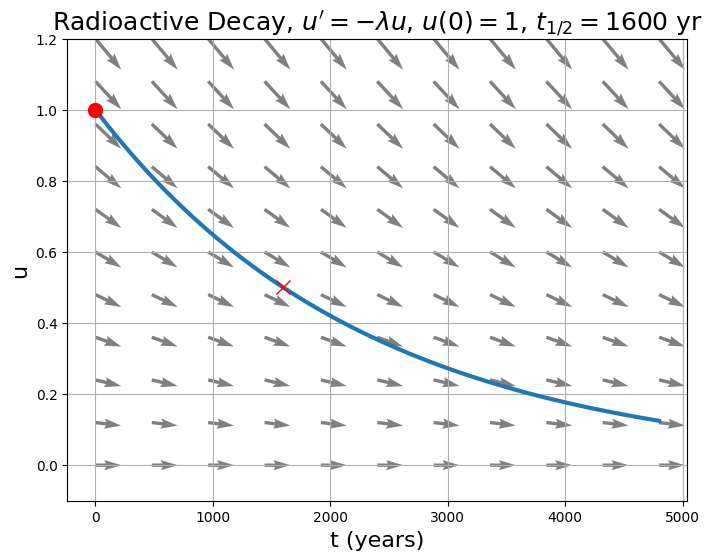

In [40]:
decay_constant = -numpy.log(2.)/1600.
t = numpy.linspace(0., 4800, 11)
y = numpy.linspace(0., 1.2, 11)
T, Y = numpy.meshgrid(t,y)
dt = numpy.ones(T.shape)
dy = -dt*Y

tp = numpy.linspace(0., 4800, 100)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.quiver(T,Y, dt,dy,linewidth=0.1,color='gray')
axes.plot(tp,numpy.exp(decay_constant*tp),linewidth=3)
axes.plot(0.,1.,'ro', markersize=10)
axes.plot(1600., 0.5,'rx',markersize=10)
axes.grid()
axes.set_title("Radioactive Decay, $u' = - \lambda u$, $u(0)=1$, $t_{1/2}=1600$ yr", fontsize=18)
axes.set_xlabel('t (years)', fontsize=16)
axes.set_ylabel('u', fontsize=16)

axes.set_ylim((-.1,1.2))
plt.show()



#### Examples:  Complex radioactive decay (or chemical system).

Chain of decays from one species to another.

$$\begin{aligned}
    \frac{\text{d} c_1}{\text{d}t} &= -\lambda_1 c_1 \\
    \frac{\text{d} c_2}{\text{d}t} &= \lambda_1 c_1 - \lambda_2 c_2 \\
    \frac{\text{d} c_3}{\text{d}t} &= \lambda_2 c_2 - \lambda_3 c_3
\end{aligned}$$

$$\frac{\text{d} \mathbf{u}}{\text{d}t} = \frac{\text{d}}{\text{d}t}\begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix} =
\begin{bmatrix}
    -\lambda_1 & 0 & 0 \\
    \lambda_1 & -\lambda_2 & 0 \\
    0 & \lambda_2 & -\lambda_3
\end{bmatrix} \begin{bmatrix} c_1 \\ c_2 \\ c_3 \end{bmatrix}$$

$$\frac{\text{d} \mathbf{u}}{\text{d}t} = A \mathbf{u}$$

For systems of equations like this the general solution to the ODE is the matrix exponential:

$$\mathbf{u}(t) = e^{A t}\mathbf{u}_0 = \sum_{i=1}^3 c_i\mathbf{s}_i e^{-\lambda_i t}$$

which can be solved given the eigenvalues and eigenvectors of $A$.

#### Examples:  Particle tracking in a fluid

$$\frac{\text{d} \mathbf{X}}{\text{d}t} = \mathbf{V}(t, \mathbf{X})$$

In fact all ODE IVP systems can be thought of as tracking particles through a flow field (dynamical system).  In 1-dimension the flow "manifold" we are on is fixed by the initial condition.

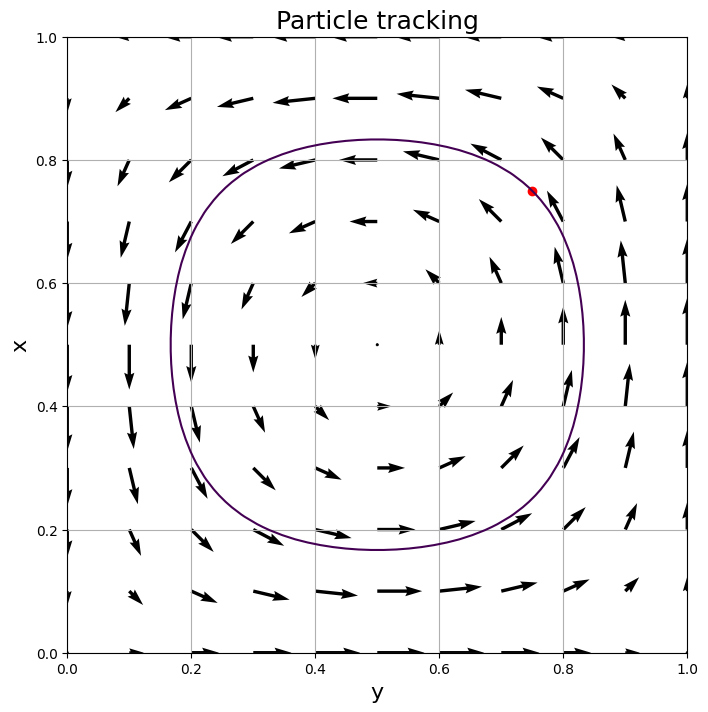

In [41]:
x = numpy.linspace(0., 1., 11)
y = numpy.linspace(0., 1., 11)
x_fine = numpy.linspace(0., 1.)
y_fine = numpy.linspace(0., 1.)

X, Y = numpy.meshgrid(x,y)
X_fine, Y_fine = numpy.meshgrid(x_fine, y_fine)

pi = numpy.pi
psi = numpy.sin(pi*X_fine)*numpy.sin(pi*Y_fine)
U = pi*numpy.sin(pi*X)*numpy.cos(pi*Y)
V = -pi*numpy.cos(pi*X)*numpy.sin(pi*Y)

x0 = 0.75
y0 = 0.75
psi0 = numpy.sin(pi*x0)*numpy.sin(pi*y0)

fig = plt.figure(figsize=(8,8))
axes = fig.add_subplot(1, 1, 1)
axes.quiver(X,Y, U, V)
axes.plot(.75, 0.75,'ro')
axes.contour(X_fine, Y_fine, psi, [ psi0 ])
axes.grid()
axes.set_title("Particle tracking", fontsize=18)
axes.set_xlabel('y', fontsize=16)
axes.set_ylabel('x', fontsize=16)

plt.show()

#### Examples: Van der Pol Oscillator

$$y'' - \mu (1 - y^2) y' + y = 0 \quad \quad \text{with} \quad \quad  y(0) = y_0, \quad y'(0) = v_0$$


$$\mathbf{u} = \begin{bmatrix} y \\ y' \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$
   
$$\frac{\text{d}}{\text{d}t} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} u_2 \\ \mu (1 - u_1^2) u_2 - u_1 \end{bmatrix} = \mathbf{f}(t, \mathbf{u})$$

In [42]:
from scipy.integrate import solve_ivp

def f_vanderpol(t, u, mu=5.):
    return numpy.array([u[1], mu * (1.0 - u[0]**2) * u[1] - u[0]])

N = 100
t_span = (0., 50.)
u0 = [ 1., 1. ]
f = lambda t, u: f_vanderpol(t, u, mu=5)
sol = solve_ivp(f, t_span, u0,method='BDF',rtol=1.e-8)

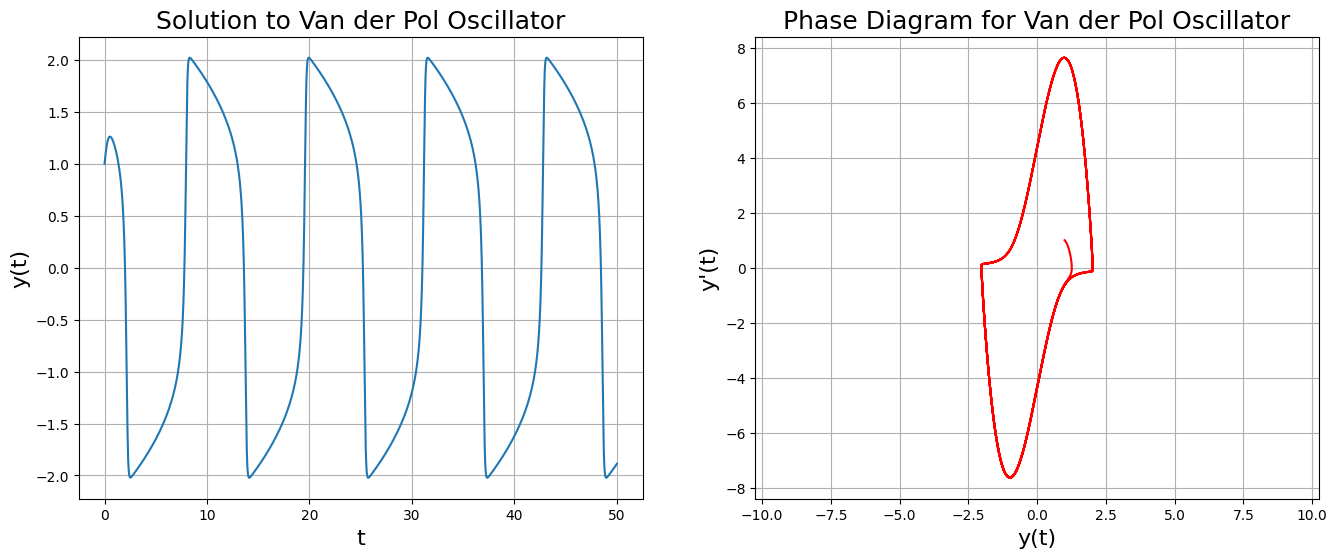

In [43]:
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)

axes.plot(sol.t, sol.y[0])
axes.set_title("Solution to Van der Pol Oscillator", fontsize=18)
axes.set_xlabel("t", fontsize=16)
axes.set_ylabel("y(t)", fontsize=16)
axes.grid()

axes = fig.add_subplot(1, 2, 2)

axes.plot(sol.y[0],sol.y[1],'r')
axes.set_title("Phase Diagram for Van der Pol Oscillator", fontsize=18)
axes.set_xlabel("y(t)", fontsize=16)
axes.set_ylabel("y'(t)", fontsize=16)
axes.axis('equal')
axes.grid()
plt.show()

#### Examples: the Lorenz Equations

The Lorenz Equations are a simplified model of atmospheric convection that are described by a non-linear system of three equations

$$
\begin{aligned}
\frac{dx}{dt} & = \sigma(y-x) \\
\frac{dy}{dt} & = \rho x - y - xz \\
\frac{dz}{dt} & = -\beta z + xy
\end{aligned}
$$

and was one of the first systems to display "deterministic Chaos" or sensitivity to initial conditions.

In [44]:
from scipy.integrate import solve_ivp

def f_lorenz(t, u, sigma, beta, rho):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = u
        return numpy.array([sigma * (y - x),
                            x * (rho - z) - y,
                            x * y - beta * z])

t_span = (0., 20)
sigma = 10.
beta = 8./3.
rho = 28.0

u0 = numpy.array([ 5., 5., 10.0])
sol = solve_ivp(f_lorenz, t_span, u0,args=(sigma, beta, rho), method='RK45',rtol=1.e-8)

u1 = u0 + numpy.array([0., 0., 0.00001])
sol1 = solve_ivp(f_lorenz, t_span, u1,args=(sigma, beta, rho), method='RK45',rtol=1.e-8)


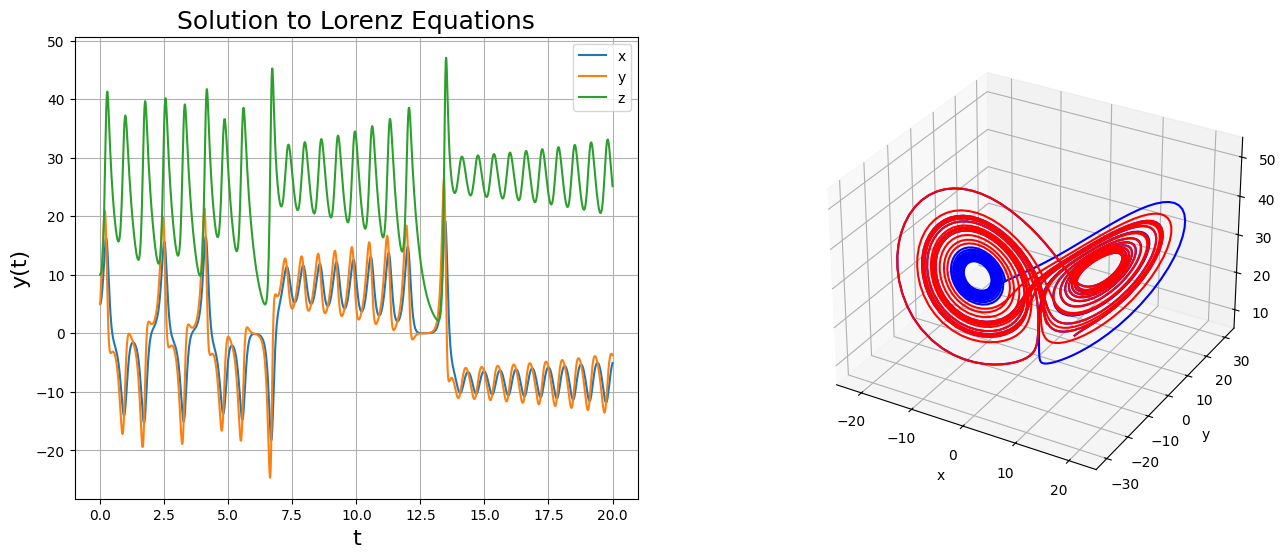

In [45]:
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)

axes.plot(sol.t, sol.y.T)
axes.set_title("Solution to Lorenz Equations", fontsize=18)
axes.set_xlabel("t", fontsize=16)
axes.set_ylabel("y(t)", fontsize=16)
axes.legend(['x','y','z'],loc='best')
axes.grid()

ax = fig.add_subplot(1,2,2, projection='3d')
ax.axis('on')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))

ax.plot(sol.y[0],sol.y[1], sol.y[2],'b')
ax.plot(sol1.y[0], sol1.y[1], sol1.y[2],'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.view_init(30,104)
plt.show()

## The Big Questions

Given a RHS $\mathbf{f}(t,\mathbf{u})$ and initial condition $\mathbf{u}(t_0) \ldots$

*  How do you find a discrete numerical solution that approximates the trajectory $\mathbf{u}(t)$?
*  How do you control the accuracy of the approximation?
*  How do you improve the efficiency of the approximation?
*  How do you understand  stability and convergence?

## Some Notation:  Basic Stepping schemes

Introducing some notation to simplify things
$$\begin{aligned}
    t_0 &= 0 \\
    t_1 &= t_0 + \Delta t \\
    t_n &= t_{n-1} + \Delta t = n \Delta t + t_0 \\
    u_0 &= u(t_0) \approx U_0 \\
    u_1 &= u(t_1) \approx U_1 \\
    u_n &= u(t_n) \approx U_2 \\
\end{aligned}$$
where lower-case letters are "exact".  

Looking back at our work on numerical differentiation why not approximate the derivative as a finite difference:

$$
    \frac{u(t + \Delta t) - u(t)}{\Delta t} = f(t, u)
$$

We still need to decide how to evaluate the $f(t, u)$ term however.  

One obvious way to do this, is to just use $f(t, u(t))$ and write the update scheme as

$$
    u(t + \Delta t) = u(t) + \Delta t f(t,u(t))
$$

Which is our first integration scheme (which goes by the name Euler's method).  As usual, though the first scheme is often the worst scheme, but with a bit of understanding we can do much better with not a lot more work.

### Integral form of ODE IVP's: the  Relationship to quadrature

Euler's method is an example of a "Single Step, multi-stage" scheme of which there are many.  However, to derive them it is actually more instructive to work with the integral form of an ODE, which will put the equations in a form where we can use our ideas from quadrature to make progress

Given a a system of ODE's
$$
    \frac{d\mathbf{u}}{dt} = \mathbf{f}(t,\mathbf{u})
$$

We can integrate both sides
$$
    \int^{t + \Delta t}_t \frac{d\mathbf{u}}{d \tau} d\tau = \int^{t + \Delta t}_t \mathbf{f}(\tau, \mathbf{u}) d\tau
$$

which is equivalent to the differential form.

 However using the fundamental theorem of calculus tells us that the LHS is $u(t + \Delta t) - u(t)$  so we can write the ODE as

$$
   \mathbf{u}(t + \Delta t) = \mathbf{u}(t) + \int^{t + \Delta t}_t \mathbf{f}(\tau, \mathbf{u}(\tau)) d\tau
$$

## Single-Step Multi-Stage Schemes

The integral form of an ODE initial value problem can be written

$$
    u(t + \Delta t) = u(t) + \int^{t + \Delta t}_t f(\tau, u(\tau)) d\tau
$$

Which says that our solution $u$, if it exists  at some time $\Delta t$ in the future,  is $u(t)$ plus a *number*

$$
    K = \int^{t + \Delta t}_t f(\tau, u(\tau) )d\tau
$$

which is a definite *line integral* (along an unknown solution).

An important class of ODE solvers are called *Single Step, Multi-stage schemes* which can be most easily understood as extensions of the  Newton-Cotes quadrature schemes for approximating $K$ (plus an error term that will scale as $\Delta t^p$)

### The Geometric picture


<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:29: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-398883618.py:23: SyntaxWarning: invalid escape sequence '\D'
  axes.text(900., uK - .1, '$\Delta t$', fontsize=24, color='red')
/tmp/ipython-input-398883618.py:29: SyntaxWarning: invalid escape sequence '\l'
  axes.set_title("Direction Set, $u' = - \lambda u$, $u(0)=1$", fontsize=18)


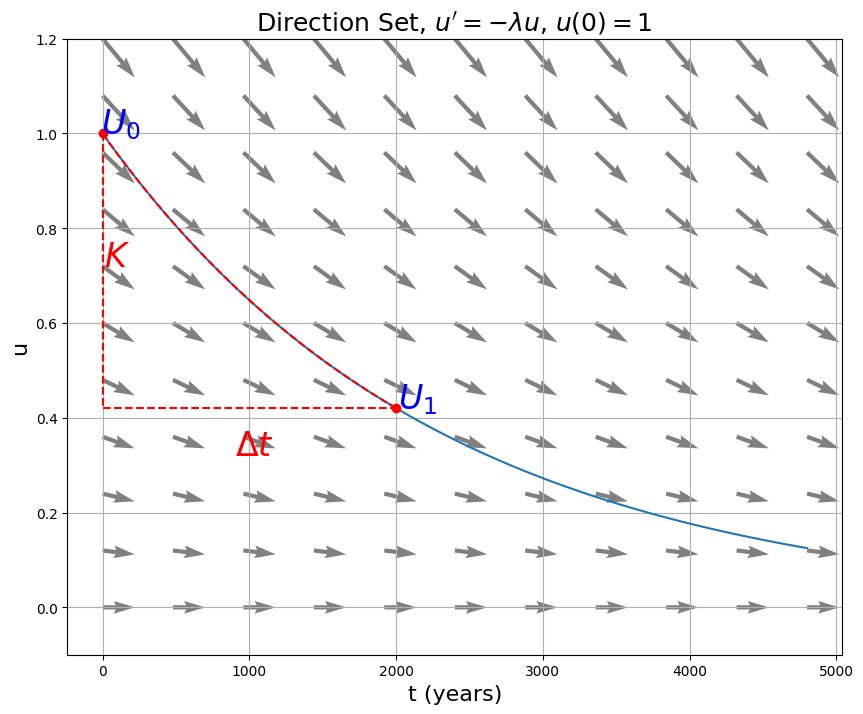

In [46]:
t = numpy.linspace(0., 4800, 11)
y = numpy.linspace(0., 1.2, 11)
T, Y = numpy.meshgrid(t,y)
dt = numpy.ones(T.shape)
dy = -dt*Y

tK = 2000.
uK = numpy.exp(decay_constant*tK)
K = uK -1.
tp = numpy.linspace(0., 4800, 100)
tk = numpy.linspace(0., tK, 100)

fig = plt.figure(figsize=(10,8))
axes = fig.add_subplot(1, 1, 1)
axes.quiver(T,Y, dt,dy, color='gray')
axes.plot(tp,numpy.exp(decay_constant*tp))
axes.plot(0.,1.,'ro')
axes.plot(tk,numpy.exp(decay_constant*tk),'r--')
axes.plot(tK, uK, 'ro')
axes.plot([0.,0.], [1., uK], 'r--')
axes.text(10., 0.72, '$K$', fontsize=24, color='red')
axes.plot([0.,tK],[uK, uK], 'r--')
axes.text(900., uK - .1, '$\Delta t$', fontsize=24, color='red')
axes.text(-10, 1., '$U_0$', fontsize=24, color='blue')
axes.text(tK+10, uK, '$U_1$', fontsize=24, color='blue')


axes.grid()
axes.set_title("Direction Set, $u' = - \lambda u$, $u(0)=1$", fontsize=18)
axes.set_xlabel('t (years)', fontsize=16)
axes.set_ylabel('u', fontsize=16)

axes.set_ylim((-.1,1.2))
plt.show()



#### Exercise (left for the reader)

Show that
$$
    u(\Delta t) = u_0 + \int_0^{\Delta t} f(\tau, u(\tau)) d\tau
$$

when $f(\tau, u(\tau)) = -\lambda u(\tau)$ and $u(\tau) = u_0e^{-\lambda \tau}$

#### Forward Euler scheme
For example, if we approximate $K$ with a left-sided quadrature rule
$$
    K = \int^{t + \Delta t}_t f(\tau, u(\tau)) d\tau \approx \Delta t f(t, u(t))
$$

then our first ODE algorithm can be written
$$
u(t + \Delta t) =  u(t) + \Delta t f(t, u(t))
$$

Which is exactly Euler's method that we derived previously

in terms of our discrete approximation $U$
$$
\begin{align}
    K_1 &= \Delta t f(t_n, U_n)\\
    U_{n+1} &= U_n + K_1\\
\end{align}
$$

 known as the *forward Euler method*.  In essence we are approximating the derivative with the value of the function at the point we are at $t_n$.

In [47]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

# Euler step
dt = 1e3
u_np = c_0 + dt * (decay_constant * c_0)

<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1252924295.py:11: SyntaxWarning: invalid escape sequence '\D'
  axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)


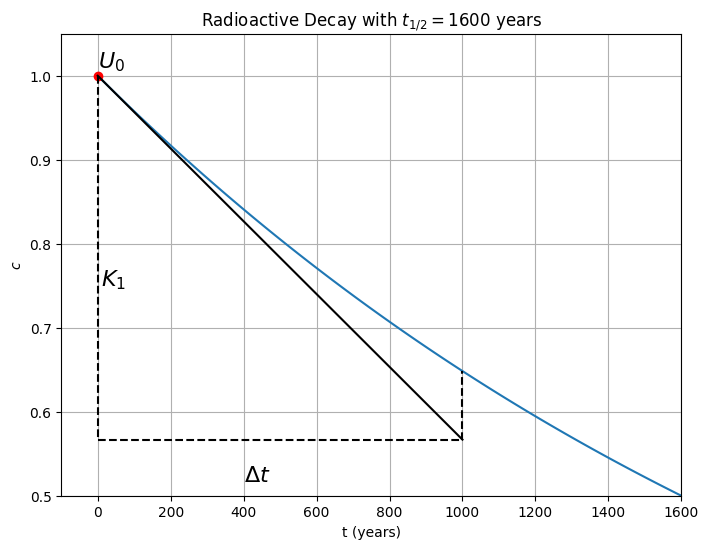

In [48]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(decay_constant * t), label="True Solution")
axes.plot(0., 1., 'ro')
axes.text(0., 1.01, '$U_0$', fontsize=16)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.text(10., 0.75, '$K_1$', fontsize=16)
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.05))
axes.grid()
plt.show()

In [49]:
# Implement Forward Euler
def euler(f, t_span, u0, N):
    """ simple implementation of constant step-size forward euler method
        This doc string should have so much more in it
    """
    t = numpy.linspace(t_span[0], t_span[1],N)
    u = numpy.empty(t.shape)
    u[0] = u0
    delta_t = t[1] - t[0]
    for (n, t_n) in enumerate(t[:-1]):
        K1 = delta_t * f(t_n, u[n])
        u[n + 1] = u[n] + K1
    return t, u

In [50]:
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

t_span = [0.0, 1.6e3]
u0 = 1.
N = 11
t_euler, u_euler = euler(f, t_span, u0, N)


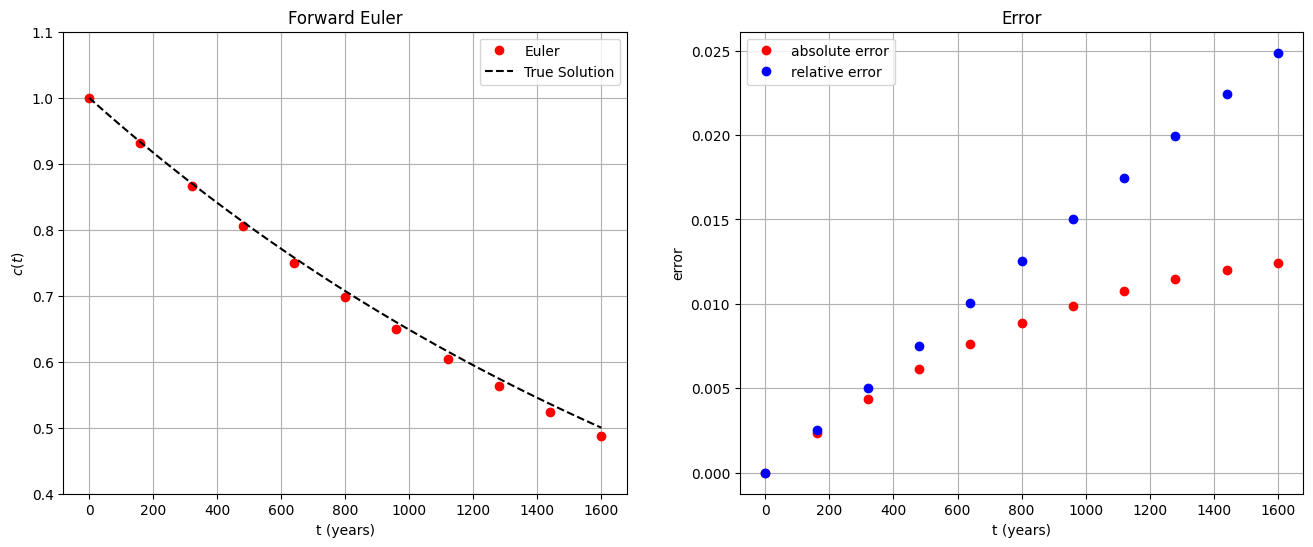

In [51]:
t_exact = numpy.linspace(0.0, 1.6e3, 100)
u_exact = lambda t : c_0 * numpy.exp(decay_constant * t)

fig = plt.figure(figsize=(16, 6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(t_euler, u_euler, 'or', label="Euler")
axes.plot(t_exact, u_exact(t_exact), 'k--', label="True Solution")

axes.set_title("Forward Euler")
axes.set_xlabel("t (years)")
axes.set_ylabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.grid()
axes.legend()

abs_err = numpy.abs(u_euler - u_exact(t_euler))
rel_err = abs_err/u_exact(t_euler)
axes = fig.add_subplot(1, 2, 2)
axes.plot(t_euler,abs_err,'ro',label='absolute error')
axes.plot(t_euler,rel_err,'bo',label='relative error')
axes.set_xlabel("t (years)")
axes.set_ylabel("error")
axes.set_title('Error')
axes.legend(loc='best')
axes.grid()

plt.show()

### Backward's Euler

Similar to forward Euler is the *backward Euler* method which,   uses a right-rectangle rule to estimate $K$ given $f$ at a future time. i.e.

$$
    K\approx \Delta t f(t_{n+1}, U_{n+1})
$$

However, the update scheme now becomes
$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}).
$$

which requires a (usually non-linear) solve for $U_{n+1}$. Schemes where the function $f$ is evaluated at the unknown time are called *implicit methods*.

For some cases we can solve the equation by hand.  For instance in the case of our example problem, $f=\lambda U$, we have:

$$
    U_{n+1} = U_n + \Delta t f(t_{n+1}, U_{n+1}) = U_n + \Delta t (\lambda U_{n+1})
$$

which can be solved for $U_{n+1}$ to find

$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t (\lambda U_{n+1}) \\
    U_{n+1} \left[ 1 - \Delta t \lambda \right ] &= U_n \\
    U_{n+1} &= \frac{U_n}{1 - \Delta t \lambda}
\end{aligned}$$

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-123506483.py:17: SyntaxWarning: invalid escape sequence '\D'
  axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)


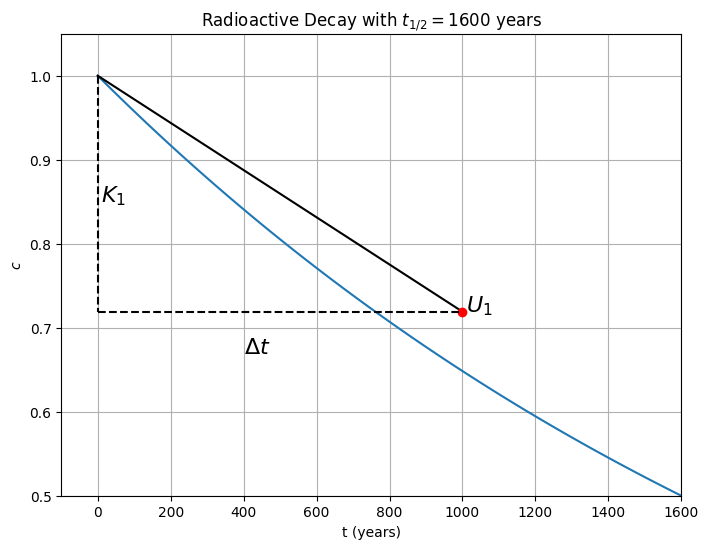

In [52]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(decay_constant * t), label="True Solution")

# Plot Backwards Euler step
dt = 1e3
u_np = c_0 + dt * (decay_constant * c_0 * numpy.exp(decay_constant * dt))
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot(dt, u_np, 'ro')
axes.text(dt+ 10., u_np, '$U_1$', fontsize=16)
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)
axes.text(10., 0.85, '$K_1$', fontsize=16)

axes.grid()
axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.05))
plt.show()

In [53]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u
n_steps = 11

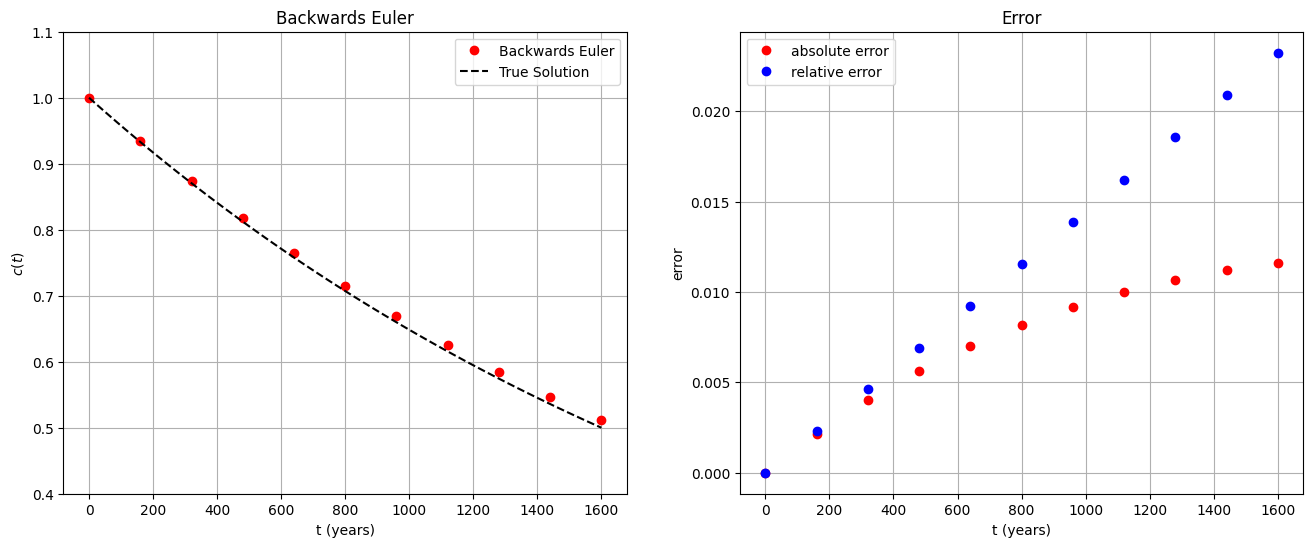

In [54]:
t_exact = numpy.linspace(0.0, 1.6e3, 100)

# Implement backwards Euler
t_backwards = numpy.linspace(0.0, 1.6e3, n_steps)
delta_t = t_backwards[1] - t_backwards[0]
u_backwards = numpy.empty(t_backwards.shape)
u_backwards[0] = c_0
for n in range(0, t_backwards.shape[0] - 1):
    u_backwards[n + 1] = u_backwards[n] / (1.0 - decay_constant * delta_t)

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(t_backwards, u_backwards, 'or', label="Backwards Euler")
axes.plot(t_exact, u_exact(t_exact), 'k--', label="True Solution")
axes.grid()
axes.set_title("Backwards Euler")
axes.set_xlabel("t (years)")
axes.set_ylabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()

abs_err = numpy.abs(u_backwards - u_exact(t_backwards))
rel_err = abs_err/u_exact(t_backwards)
axes = fig.add_subplot(1, 2, 2)
axes.plot(t_backwards,abs_err,'ro',label='absolute error')
axes.plot(t_backwards,rel_err,'bo',label='relative error')
axes.set_xlabel("t (years)")
axes.set_ylabel("error")
axes.set_title('Error')
axes.legend(loc='best')
axes.grid()

plt.show()

It's also useful to be able to do this in the case of systems of ODEs.  Let $f(U) = A U$, then

$$\begin{aligned}
    U_{n+1} &= U_n + \Delta t (A U_{n+1}) \\
     \left [ I - \Delta t A \right ]U_{n+1} &= U_n \\
    U_{n+1} &= \left [ I - \Delta t A \right]^{-1} U_n
\end{aligned}$$

In general however we are often not able to do this with arbitrary $f$.

Another simple implicit method is based on quadrature using the trapezoidal method.  The scheme is
$$
    \frac{U_{n+1} - U_{n}}{\Delta t} = \frac{1}{2} (f(U_n) + f(U_{n+1}))
$$

In this case what is the update scheme for $f(u) = \lambda u$?

$$\begin{aligned}
    U_{n+1} &= U_{n} + \frac{\Delta t}{2} (f(U_n) + f(U_{n+1})) \\
    U_{n+1} &= U_{n} + \frac{\Delta t}{2} (\lambda U_n + \lambda U_{n+1}) \\
    U_{n+1} \left[1 - \frac{\Delta t \lambda}{2}  \right] &= U_{n} \left[1 + \frac{\Delta t \lambda}{2} \right] \\
    U_{n+1} &= U_{n} \frac{1 + \frac{\Delta t \lambda}{2}}{1 - \frac{\Delta t \lambda}{2}} \\
\end{aligned}$$

In [55]:
n_steps = 11

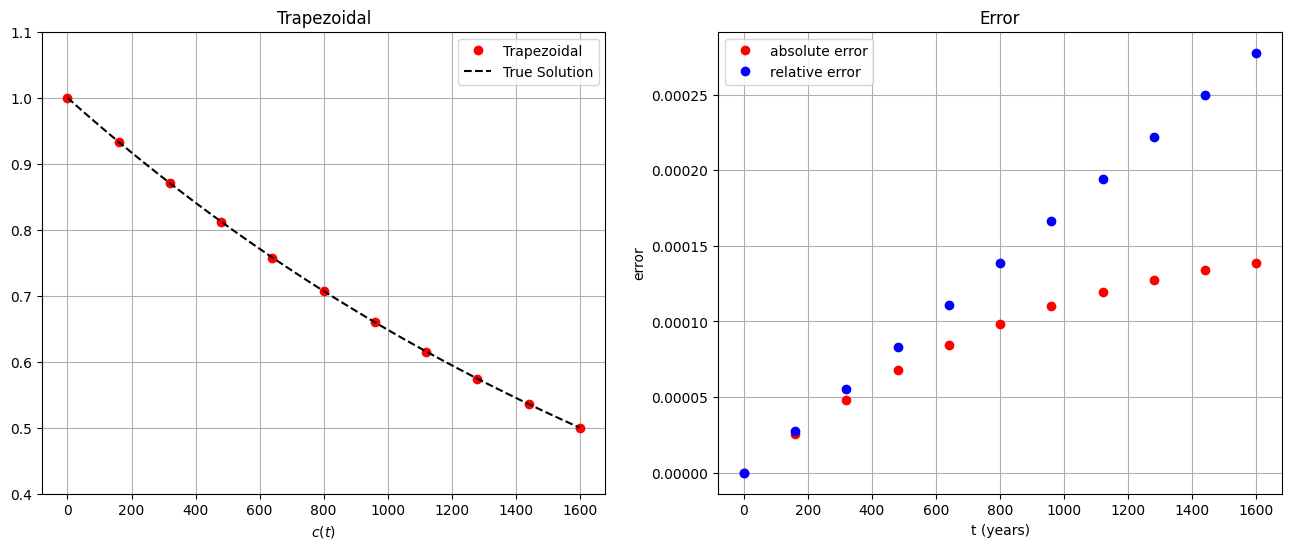

In [56]:
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0
t_exact = numpy.linspace(0.0, 1.6e3, 100)

# Implement trapezoidal method
t = numpy.linspace(0.0, 1.6e3, n_steps)
delta_t = t[1] - t[0]
u = numpy.empty(t.shape)
u[0] = c_0
integration_constant = (1.0 + decay_constant * delta_t / 2.0) / (1.0 - decay_constant * delta_t / 2.0)
for n in range(t.shape[0] - 1):
    u[n + 1] = u[n] * integration_constant

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(t, u, 'or', label="Trapezoidal")
axes.plot(t_exact, u_exact(t_exact), 'k--', label="True Solution")
axes.grid()

axes.set_title("Trapezoidal")
axes.set_xlabel("t (years)")
axes.set_xlabel("$c(t)$")
axes.set_ylim((0.4,1.1))
axes.legend()

abs_err = numpy.abs(u  - u_exact(t))
rel_err = abs_err/u_exact(t)
axes = fig.add_subplot(1, 2, 2)
axes.plot(t,abs_err,'ro',label='absolute error')
axes.plot(t,rel_err,'bo',label='relative error')
axes.set_xlabel("t (years)")
axes.set_ylabel("error")
axes.set_title('Error')
axes.legend(loc='best')
axes.grid()


plt.show()

## Error Analysis of ODE Methods

At this point it is also helpful to introduce more notation to distinguish between the true solution to the ODE $u(t_n)$ and the approximated value which we will denote $U_n$.

**Definition:** We define the *truncation error* of a scheme by replacing the $U_n$ with the true solution $u(t_n)$ in the finite difference formula and looking at the difference from the exact solution.

For example we will use the difference form of forward Euler
$$
    \frac{U_{n+1} - U_n}{\Delta t} = f(t_n,U_n)
$$
and define the truncation error as
$$
    T(t, u; \Delta t) = \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - f(t_n, u(t_n)).
$$

**Definition:** A method is called *consistent* if
$$
    \lim_{\Delta t \rightarrow 0} T(t, u; \Delta t) = 0.
$$

**Definition:** We say that a method is *order* $p$ accurate if

$$
    \lVert T(t, u; \Delta t) \rVert \leq C \Delta t^p
$$

uniformally on $t \in [0, \tau]$.  This can also be written as $T(t, u; \Delta t) = \mathcal{O}(\Delta t^p)$.  Note that a method is consistent if $p > 0$.

### Error Analysis of Forward Euler

We can analyze the error and convergence order of forward Euler by considering the Taylor series centered at $t_n$:

$$
    u(t) = u(t_n) + (t - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t - t_n)^2 + \mathcal{O}((t-t_n)^3)
$$

Evaluating this series at $t_{n+1}$ gives

$$\begin{aligned}
    u(t_{n+1}) &= u(t_n) + (t_{n+1} - t_n) u'(t_n) + \frac{u''(t_n)}{2} (t_{n+1} - t_n)^2 + \mathcal{O}((t_{n+1}-t_n)^3)\\
    &=u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3)
\end{aligned}$$

From the definition of truncation error we can use our Taylor series expression and find the truncation error.  Take the finite difference form of forward Euler

$$
    \frac{U_{n+1} - U_n}{\Delta t} = f(t_n, U_n)
$$

and replacing the derivative formulation with $u(t_n)$ to find

$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{u(t_{n+1}) - u(t_n)}{\Delta t} - f(t_n, u_n) \\
\end{aligned}$$

Given the Taylor's series expansion for $u(t_{n+1})$

$$
u(t_{n+1}) =u(t_n) + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3)
$$

We substitute to find
$$
    T(t, u; \Delta t)  = \frac{u''(t_n)}{2} \Delta t + \mathcal{O}(\Delta t^2).
$$

This implies that forward Euler is first order accurate and therefore consistent.

Another equivalent definition of the truncation error uses the form
$$
    U_{n+1} = u(t_n) + \Delta t f(t_n)
$$
and the definition
$$
    T(t, u; \Delta t) = \frac{1}{\Delta t} \left [ U_{n+1} - u(t_{n+1}) \right]
$$

to find
$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} [U_{n+1} - u(t + \Delta t)] \\
    &= \frac{1}{\Delta t} \left[ \underbrace{u_n + \Delta t f(t_n, u_n)}_{U_{n+1}} - \underbrace{\left( u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right )}_{u(t_{n+1})}\right ] \\
    &= \frac{1}{\Delta t} \left[ - \frac{u''(t_n)}{2} \Delta t^2 - \mathcal{O}(\Delta t^3) \right ] \\
    &= - \frac{u''(t_n)}{2} \Delta t - \mathcal{O}(\Delta t^2)
\end{aligned}$$

#### Truncation Error vs Step Error

Sometimes we will also consider the "Step Error"  which is the error that is introduced over one step

$$
    E_h = | U_{n+1} - u_{n+1} |
$$

This leads to an alternate definition of the truncation error as

$$
    T(t,u;\Delta t) = \frac{E_h}{\Delta t} = \frac{1}{\Delta t} [U_{n+1} - u_{n+1}]
$$

so if the Truncation error is $O(\Delta t^p)$ then the step error will be order $O(\Delta t^{p+1})$

So for Forward (or Backward's) Euler the step error

$$
    E_h = O(\Delta t^2)
$$

The step error can be very useful in *adaptive stepping* schemes

## Review: Single-Step Multi-Stage Schemes

Given the differential form of an ODE IVP

$$
    \frac{d\mathbf{u}}{dt} = \mathbf{f}(t,\mathbf{u})
$$



We can integrate both sides
$$
    \int^{t + \Delta t}_t \frac{d\mathbf{u}}{d \tau} d\tau = \int^{t + \Delta t}_t \mathbf{f}(\tau, \mathbf{u}) d\tau
$$

 to generate its integral form

$$
    \mathbf{u}(t + \Delta t) = \mathbf{u}(t) + \int^{t + \Delta t}_t \mathbf{f}(\tau, \mathbf{u}(\tau)) d\tau
$$

Which says that our solution $\mathbf{u}$, if it exists  at some time $\Delta t$ in the future,  is $\mathbf{u}(t)$ plus a *vector*

$$
    \mathbf{K} = \int^{t + \Delta t}_t \mathbf{f}(\tau, \mathbf{u}(\tau) )d\tau
$$

which is a definite *line integral* (along an unknown solution).

An important class of ODE solvers are called *Single Step, Multi-stage schemes* which can be most easily understood as extensions of the  Newton-Cotes quadrature schemes for approximating $\mathbf{K}$ (plus an error term that will scale as $\Delta t^p$)

## Runge-Kutta Methods

One way to derive higher-order ODE solvers is to use higher order quadrature schemes that sample the function at a number of  intermediate stages to provide a more accurate estimate of $K$.  These are not *multi-step* methods as they still only require information from the current time step but they raise the order of accuracy by adding *stages*.  These types of methods are called **Runge-Kutta** methods.

i.e. There is only one $\Delta t$, but we tak multiple samples during that $\Delta t$.

### Example:  One-stage Runge-Kutta Scheme (Forward Euler)

For example, if we approximate $K$ with a left-sided quadrature rule
$$
    K = \int^{t + \Delta t}_t f(\tau, u(\tau)) d\tau \approx \Delta t f(t, u(t))
$$

then our first ODE algorithm can be written
$$
u(t + \Delta t) =  u(t) + \Delta t f(t, u(t))
$$

in terms of our discrete approximation $U$
$$
\begin{align}
    K_1 &= \Delta t f(t_n, U_n)\\
    U_{n+1} &= U_n + K_1\\
\end{align}
$$

which is the  *forward Euler method*.  In essence we are approximating the derivative with the value of the function at the point we are at $t_n$.

<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-849316547.py:19: SyntaxWarning: invalid escape sequence '\D'
  axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)


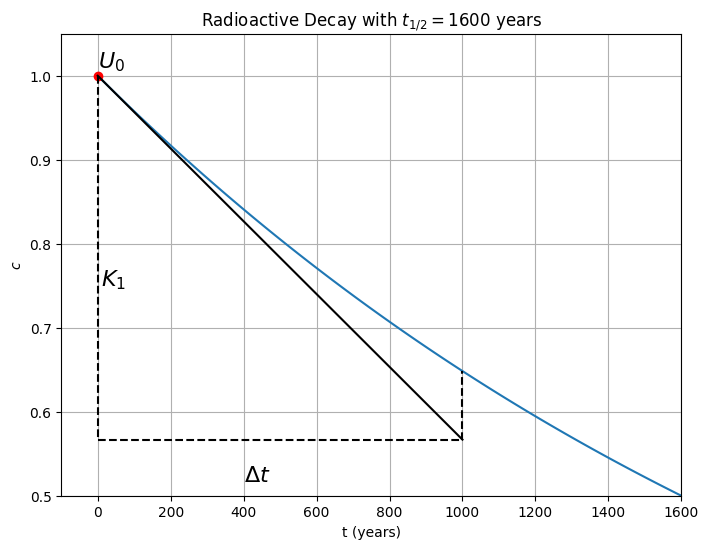

In [57]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

# Euler step
dt = 1e3
u_np = c_0 + dt * (decay_constant * c_0)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(decay_constant * t), label="True Solution")
axes.plot(0., 1., 'ro')
axes.text(0., 1.01, '$U_0$', fontsize=16)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.text(10., 0.75, '$K_1$', fontsize=16)
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)

axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.05))
axes.grid()
plt.show()

For any solution with curvature, there is clearly a step error $|U_n -u_n|$ which for Euler is $O(\Delta t^2 f'')$

### Example:  Two-stage Runge-Kutta Methods

Similarly, the two-stage Runge-Kutta methods RK2  approximates $K$ using a mid-point scheme (which should be 2nd order accurate).  Unfortunately, we don't know the value of the mid-point.  However we can use an Euler step of size $\Delta t/2$ to estimate the mid-point.  

We can write the algorithm as

$$\begin{aligned}
    K_1 &= \Delta t f(U_n, t_n) \\
    K_2 &= \Delta t f(U_n + K_1/2, t_n + \Delta t/2 )\\
    U_{n+1} &= U_n + K_2 \\    
\end{aligned}$$

Where we now evaluate the function in two stages $K_1$ and $K_2$.


In [58]:
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

# RK2 step
dt = 1e3
U0 = 1.0


K1 = dt * f(0., U0)
K2 = dt * f(dt/2., U0 + K1/2)

U1 = U0 + K2

<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:14: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-936823046.py:14: SyntaxWarning: invalid escape sequence '\D'
  axes.text(250, Y1 - 0.05, '$\\frac{\Delta t}{2}$', fontsize=18)
/tmp/ipython-input-936823046.py:20: SyntaxWarning: invalid escape sequence '\D'
  axes.text(250, Y1 - 0.05, '$\\frac{\Delta t}{2}$', fontsize=18)


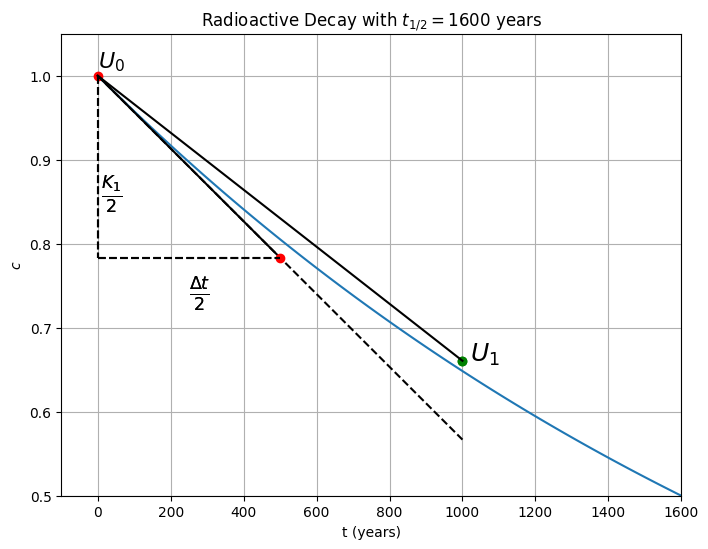

In [59]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U0 * numpy.exp(decay_constant * t), label="True Solution")
axes.plot(0., U0, 'ro')
axes.text(0., U0+.01, '$U_0$', fontsize=16)
axes.plot((0.0, dt), (U0, U0 + K1), 'k--')
axes.plot((0.0, dt/2.), (U0, U0 + K1/2.), 'k')

Y1 = U0 + K1/2
axes.plot(dt/2., U0 + K1/2, 'ro')
axes.plot((0.0, 0.0), (U0, Y1), 'k--')
axes.text(10., 0.85, '$\\frac{K_1}{2}$', fontsize=18)
axes.plot((0.0, dt/2), (Y1, Y1), 'k--')
axes.text(250, Y1 - 0.05, '$\\frac{\Delta t}{2}$', fontsize=18)

axes.plot(dt, U1, 'go')
axes.plot((0.0, 0.0), (U0, Y1), 'k--')
axes.text(10., 0.85, '$\\frac{K_1}{2}$', fontsize=18)
axes.plot((0.0, dt/2), (Y1, Y1), 'k--')
axes.text(250, Y1 - 0.05, '$\\frac{\Delta t}{2}$', fontsize=18)

axes.plot(dt, U1, 'go')
axes.plot((0., dt), (U0, U1), 'k')
axes.text(dt+20, U1, '$U_1$', fontsize=18)
#axes.plot((0.0, 0.0), (U0, U1), 'g--')
#axes.plot((0.0, dt), (U1, U1), 'g--')



axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.05))
axes.grid()
plt.show()

Find the slope at the midpoint (found using K1) to find K2 and then use K2 to get me from U0 to U1.

#### Error analysis RK2

The truncation error can be computed similarly to how we did so before but we do need to figure out how to compute the derivative inside of the function.  Note that due to

$$
    u'(t_n) = f(u(t_n))
$$

that differentiating this with respect to $t$ leads to

$$
    u''(t_n) = f'(u(t_n)) u'(t_n)
$$

leading to
$$\begin{aligned}
    f\left(u(t_n) + \frac{1}{2} \Delta t f(u(t_n)) \right ) &= f\left(u(t_n) +\frac{1}{2} \Delta t u'(t_n) \right ) \\
    &= f(u(t_n)) + \frac{1}{2} \Delta t u'(t_n) f'(u(t_n)) + \frac{1}{8} \Delta t^2 (u'(t_n))^2 f''(u(t_n)) + \mathcal{O}(\Delta t^3) \\
    &=u'(t_n) + \frac{1}{2} \Delta t u''(t_n) + \mathcal{O}(\Delta t^2)
\end{aligned}$$

Using our alternative definition of the truncation error we have

$$
        T(t, u; \Delta t) = \frac{1}{\Delta t} \left[U_{n+1} - u_{n+1} \right]
$$
or

$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} \left[u_n + \Delta t f\left(u_n + \frac{1}{2} \Delta t f(u_n)\right) - \left(u_n + \Delta t f(t_n, u_n) + \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right ) \right] \\
    &=\frac{1}{\Delta t} \left[\Delta t u'(t_n) + \frac{1}{2} \Delta t^2 u''(t_n) + \mathcal{O}(\Delta t^3) - \Delta t u'(t_n) - \frac{u''(t_n)}{2} \Delta t^2 + \mathcal{O}(\Delta t^3) \right] \\
    &= \mathcal{O}(\Delta t^2)
\end{aligned}$$

so this method is second order accurate.

### Example:  Improved Euler's method

The Improved Euler's method is another RK2 scheme but instead of approximating a mid-point quadrature rule, it approximates a trapezoidal rule.   

We can write the algorithm as

$$\begin{aligned}
    K_1 &= \Delta t f(U_n, t_n) \\
    K_2 &= \Delta t f(U_n + K_1, t_n + \Delta t )\\
    U_{n+1} &= U_n + \frac{1}{2}\left[K_1 +K_2\right] \\    
\end{aligned}$$

Where we now use function evaluations at both the initial value, and at the euler point but take the average of those slopes.

Again, error analysis shows that this scheme also has a truncation error $T(t,u:\Delta t) = \mathcal{O}(\Delta t^2)$

In [60]:
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

# Improved Euler step
dt = 1e3
U0 = 1.0

K1 = dt * f(0., U0)
K2 = dt * f(dt, U0 + K1)

U1 = U0 + 0.5*(K1 + K2)

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-3161228606.py:13: SyntaxWarning: invalid escape sequence '\D'
  axes.text(350, Y1 - 0.05, '$\\frac{\Delta t}{2}$', fontsize=18)


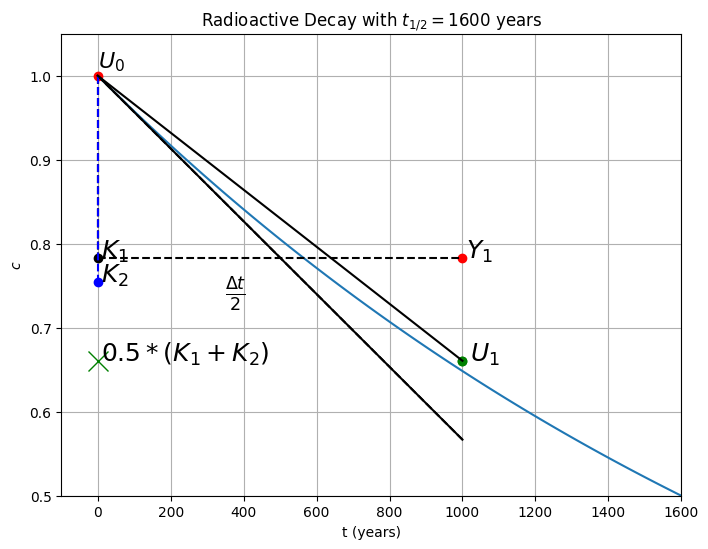

In [61]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U0 * numpy.exp(decay_constant * t), label="True Solution")
axes.plot(0., U0, 'ro')
axes.text(0., U0+.01, '$U_0$', fontsize=16)
axes.plot((0.0, dt), (U0, U0 + K1), 'k--')
axes.plot((0.0, dt), (U0, U0 + K1), 'k')

axes.plot(dt, Y1, 'ro')
axes.text(dt+10, Y1, '$Y_1$', fontsize=18)
axes.plot((0.0, 0.0), (U0, Y1), 'k--')
axes.plot((0.0, dt), (Y1, Y1), 'k--')
axes.text(350, Y1 - 0.05, '$\\frac{\Delta t}{2}$', fontsize=18)

axes.plot(dt, U1, 'go')
axes.plot((0.0, 0.0), (U0, Y1), 'k--')
axes.plot(0., Y1, 'ko')
axes.text(10., Y1, '$K_1$', fontsize=18)

Y1 = U0 + K1
axes.plot((0., 0.), (U0, U0+K2),'b--')
axes.plot(0., U0+K2,'bo--')
axes.text(10., U0+K2, '$K_2$', fontsize=18)


axes.plot(0., U1,'gx', markersize=15)
axes.text(10., U1, '$0.5*(K_1 +K_2)$', fontsize=18)


axes.plot(dt, U1, 'go')
axes.plot((0., dt), (U0, U1), 'k')
axes.text(dt+20, U1, '$U_1$', fontsize=18)
#axes.plot((0.0, 0.0), (U0, U1), 'g--')
#axes.plot((0.0, dt), (U1, U1), 'g--')



axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.05))
axes.grid()
plt.show()

### Example:  4-stage Runge-Kutta Method

If RK2 is related to a Mid-point quadrature scheme,  then the classic 4-stage, 4th order Runge-Kutta scheme should be reminiscent of Simpson's Quadrature rule.  It requires 4 samples of $f(t,u)$ at the beginning of the step, two-samples in the middle and one at the end, then a linear combination of those samples

$$\begin{aligned}
    K_1 &= \Delta t f(t_n, U_n) \\
    K_2 &= \Delta t f(t_n + \Delta t/2, U_n + K_1/2) \\
    K_3 &= \Delta t f(t_n + \Delta t/2, U_n + K_2/2) \\
    K_4 &= \Delta t f(t_n + \Delta t, U_n + K_3) \\
        & \\
    U_{n+1} &= U_n + \frac{1}{6} \left [K_1 + 2(K_2 + K_3)  + K_4) \right ]
\end{aligned}$$

With truncation error $T = O(\Delta t^4)$

In [62]:
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

# RK4 step
dt = 1e3
U0 = 1.0
K1 = dt * f(0., U0)
K2 = dt * f(dt/2., U0 + K1/2)
K3 = dt * f(dt/2., U0 + K2/2)
K4 = dt * f(dt, U0 + K3)

U1 = U0 + 1./6. *( K1 + 2 * (K2 + K3) + K4)

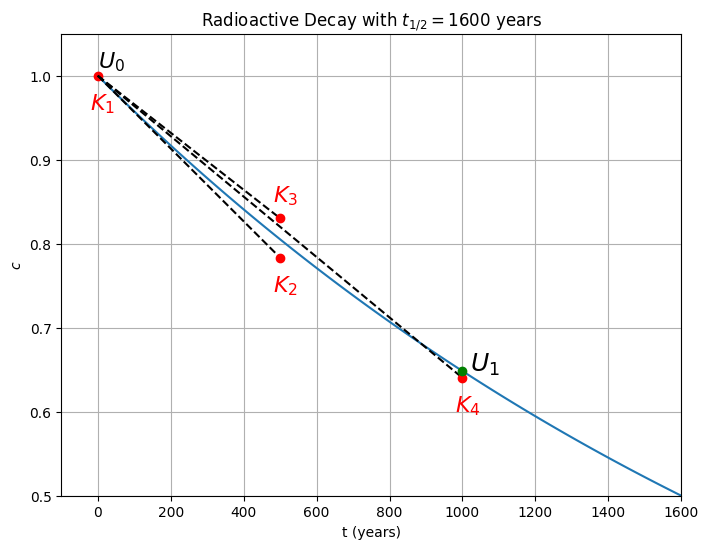

In [63]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, U0 * numpy.exp(decay_constant * t), label="True Solution")
axes.plot(0., U0, 'ro')
axes.text(0.-20, U0-.04, '$K_1$', color='red',fontsize=16)

axes.text(0., U0+.01, '$U_0$', fontsize=16)
axes.plot((0.0, dt/2.), (U0, U0 + K1/2.), 'k--')
axes.plot(dt/2., U0 + K1/2, 'ro')
axes.text(dt/2-20, U0 + K1/2-.04, '$K_2$', color='red',fontsize=16)


axes.plot((0.0, dt/2.), (U0, U0 + K2/2.), 'k--')
axes.plot(dt/2., U0 + K2/2, 'ro')
axes.text(dt/2-20, U0 + K2/2+.02, '$K_3$', color='red',fontsize=16)

axes.plot((0.0, dt), (U0, U0 + K3), 'k--')
axes.plot(dt, U0 + K3, 'ro')
axes.text(dt-20, U0 + K3-.04, '$K_4$', color='red',fontsize=16)

axes.plot(dt, U1, 'go')
#axes.plot((0., dt), (U0, U1), 'k')
axes.text(dt+20, U1, '$U_1$', fontsize=18)



axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.05))
axes.grid()
plt.show()

In [64]:
def RK2(f, t_span, u0, N):
    """ implement constant step size 2 stage Runge-Kutta Method RK2"""

    t = numpy.linspace(t_span[0], t_span[1], N)
    delta_t = t[1] - t[0]
    u = numpy.empty(t.shape)
    u[0] = u0
    for (n, t_n) in enumerate(t[:-1]):
        K_1 = delta_t * f(t_n, u[n])
        K_2 = delta_t * f(t_n + delta_t/2., u[n] + K_1/2.)
        u[n+1] = u[n] + K_2
    return t, u

def improved_euler(f, t_span, u0, N):
    """ implement constant step size 2 stage Improved Euler Method trapezoidal rule"""

    t = numpy.linspace(t_span[0], t_span[1], N)
    delta_t = t[1] - t[0]
    u = numpy.empty(t.shape)
    u[0] = u0
    for (n, t_n) in enumerate(t[:-1]):
        K_1 = delta_t * f(t_n, u[n])
        K_2 = delta_t * f(t_n + delta_t, u[n] + K_1)
        u[n+1] = u[n] + 0.5 * (K_1 + K_2)
    return t, u

In [65]:
def RK4(f, t_span, u0, N):
    """ implement constant step size 4 stage Runge-Kutta Method RK4"""

    t = numpy.linspace(t_span[0], t_span[1], N)
    delta_t = t[1] - t[0]
    u = numpy.empty(t.shape)
    u[0] = u0
    for (n, t_n) in enumerate(t[:-1]):
        K_1 = delta_t * f(t_n, u[n])
        K_2 = delta_t * f(t_n + delta_t/2., u[n] + K_1/2.)
        K_3 = delta_t * f(t_n + delta_t/2., u[n] + K_2/2.)
        K_4 = delta_t * f(t_n + delta_t, u[n] + K_3)
        u[n+1] = u[n] + 1./6. * (K_1 + 2.*( K_2 + K_3) + K_4)
    return t, u

In [66]:
# Implement and compare the two-stage and 4-stage Runge-Kutta methods
f = lambda t, u: -u
N = 21
t_span = [ 0., 5.0 ]
u0 = 1.

u_exact = lambda t: u0*numpy.exp(-t)

t_exact = numpy.linspace(t_span[0], t_span[1], 100)
t_euler, u_euler = euler(f, t_span, u0, N)
t_ieuler, u_ieuler = improved_euler(f, t_span, u0, N)
t_RK2, u_RK2 = RK2(f, t_span, u0, N)
t_RK4, u_RK4 = RK4(f, t_span, u0, N)

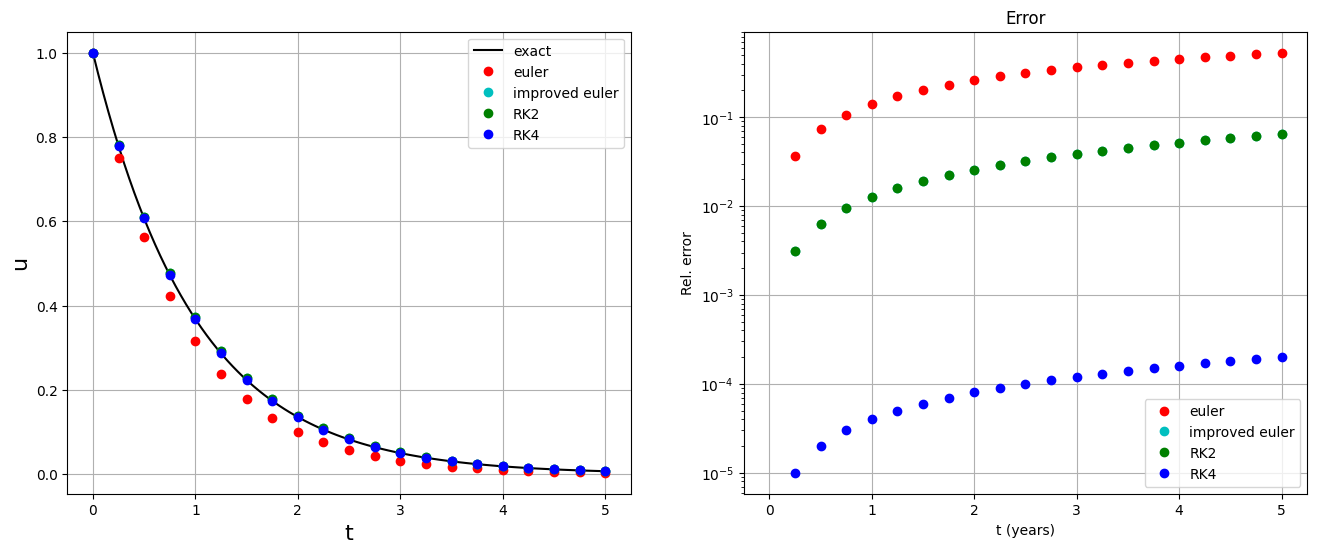

In [67]:
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(t_exact,u_exact(t_exact),'k',label='exact')
axes.plot(t_euler, u_euler, 'ro', label='euler')
axes.plot(t_ieuler, u_ieuler, 'co', label='improved euler')
axes.plot(t_RK2, u_RK2, 'go', label='RK2')
axes.plot(t_RK4, u_RK4, 'bo', label='RK4')

axes.grid()
axes.set_xlabel('t', fontsize=16)
axes.set_ylabel('u', fontsize=16)
axes.legend(loc='best')

err = lambda u, t: numpy.abs(u - u_exact(t))/u_exact(t)

axes = fig.add_subplot(1, 2, 2)

axes.semilogy(t_euler,err(u_euler,t_euler),'ro',label='euler')
axes.semilogy(t_ieuler,err(u_ieuler,t_ieuler),'co',label='improved euler')
axes.semilogy(t_RK2,err(u_RK2,t_RK2),'go',label='RK2')
axes.semilogy(t_RK4,err(u_RK4,t_RK4),'bo',label='RK4')

axes.set_xlabel("t (years)")
axes.set_ylabel("Rel. error")
axes.set_title('Error')
axes.legend(loc='best')
axes.grid()
plt.show()


### Convergence of Single Step Multi-Stage schemes

All of the above schemes are consistent and have truncation errors $T\propto\Delta t^p$

<>:49: SyntaxWarning: invalid escape sequence '\D'
<>:49: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1650939681.py:49: SyntaxWarning: invalid escape sequence '\D'
  axes.set_xlabel('$\Delta t$', fontsize=16)


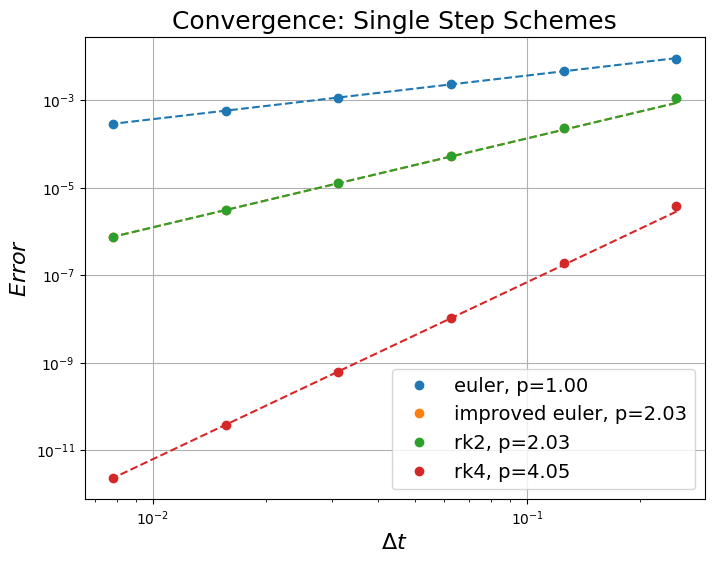

In [68]:
N = numpy.array([ 2**n for n in range(4,10)])
err_euler = numpy.zeros(len(N))
err_ieuler = numpy.zeros(len(N))
err_RK2 = numpy.zeros(len(N))
err_RK4 = numpy.zeros(len(N))

t_span = [ 0., 4.]
dt = t_span[1]/N

u0 = 1.
u_exact = u0*numpy.exp(-t_span[1])

for i, n in enumerate(N):
    t, u_euler = euler(f, t_span, u0, n)
    err_euler[i] = numpy.abs(u_euler[-1] - u_exact)
    t, u_ieuler = improved_euler(f, t_span, u0, n)
    err_ieuler[i] = numpy.abs(u_ieuler[-1] - u_exact)
    t, u_RK2 = RK2(f, t_span, u0, n)
    err_RK2[i] = numpy.abs(u_RK2[-1] - u_exact)
    t, u_RK4 = RK4(f, t_span, u0, n)
    err_RK4[i] = numpy.abs(u_RK4[-1] - u_exact)

err_fit = lambda dt, p: numpy.exp(p[1])*dt**p[0]
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

# Euler
p = numpy.polyfit(numpy.log(dt[2:]), numpy.log(err_euler[2:]),1)
line = axes.loglog(dt, err_euler, 'o', label='euler, p={:3.2f}'.format(p[0]))
axes.loglog(dt, err_fit(dt,p),'--', color=line[0].get_color())

# Improved Euler
p = numpy.polyfit(numpy.log(dt[2:]), numpy.log(err_ieuler[2:]),1)
line = axes.loglog(dt, err_ieuler, 'o', label='improved euler, p={:3.2f}'.format(p[0]))
axes.loglog(dt, err_fit(dt,p),'--', color=line[0].get_color())

# RK2
p = numpy.polyfit(numpy.log(dt[2:]), numpy.log(err_RK2[2:]),1)
line = axes.loglog(dt, err_RK2, 'o', label='rk2, p={:3.2f}'.format(p[0]))
axes.loglog(dt, err_fit(dt,p),'--', color=line[0].get_color())

#RK4
p = numpy.polyfit(numpy.log(dt[2:]), numpy.log(err_RK4[2:]),1)
line = axes.loglog(dt, err_RK4, 'o', label='rk4, p={:3.2f}'.format(p[0]))
axes.loglog(dt, err_fit(dt,p),'--', color=line[0].get_color())


axes.grid()
axes.set_xlabel('$\Delta t$', fontsize=16)
axes.set_ylabel('$Error$', fontsize=16)
axes.set_title('Convergence: Single Step Schemes', fontsize=18)
axes.legend(loc='best', fontsize=14)
plt.show()

## Summary: single-Step Multi-Stage Schemes

The integral form of an ODE initial value problem can be written

$$
    u(t + \Delta t) = u(t) + \int^{t + \Delta t}_t f(\tau, u(\tau)) d\tau
$$

Which says that our solution $u$, if it exists  at some time $\Delta t$ in the future,  is $u(t)$ plus a *number*

$$
    K = \int^{t + \Delta t}_t f(\tau, u(\tau) )d\tau
$$

which is a definite *line integral* (along an unknown solution).

#### Single Step, Multi-stage schemes

are most easily understood as extensions of the  Newton-Cotes quadrature schemes for approximating $K$ (plus an error term that will scale as $\Delta t^p$)

**Explicit Schemes**
<table width="80%">
    <tr align="center"><th>Name</th> <th align="center">Stages</th> <th align="center">"Quadrature"</th><th align="center">$$T$$</th></tr>
     <tr align="center"><td>Euler</td> <td align="center">1</td> <td align="center">Left-Rectangle</td><td align="center">$$O(\Delta t)$$</td></tr>
    <tr align="center"><td>Improved Euler</td> <td align="center">2</td> <td align="center">Trapezoidal</td><td align="center">$$O(\Delta t^2)$$</td></tr>
    <tr align="center"><td>RK2</td> <td align="center">2</td> <td align="center">Mid-Point</td><td align="center">$$O(\Delta t^2)$$</td></tr>
    <tr align="center"><td>RK4</td> <td align="center">4</td> <td align="center">Simpson</td><td align="center">$$O(\Delta t^4)$$</td></tr>
</table>

**Implicit Schemes**
<table width="80%">
    <tr align="center"><th>Name</th> <th align="center">Stages</th> <th align="center">"Quadrature"</th><th align="center">$$T$$</th></tr>
     <tr align="center"><td>Backwards-Euler</td> <td align="center">1</td> <td align="center">Right-Rectangle</td><td align="center">$$O(\Delta t)$$</td></tr>
    <tr align="center"><td>Trapezoidal</td> <td align="center">2</td> <td align="center">Trapezoidal</td><td align="center">$$O(\Delta t^2)$$</td></tr>
</table>

### Convergence of Single Step Multi-Stage schemes

All of the above schemes are consistent and have truncation errors $T\propto\Delta t^p$

<>:49: SyntaxWarning: invalid escape sequence '\D'
<>:49: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1650939681.py:49: SyntaxWarning: invalid escape sequence '\D'
  axes.set_xlabel('$\Delta t$', fontsize=16)


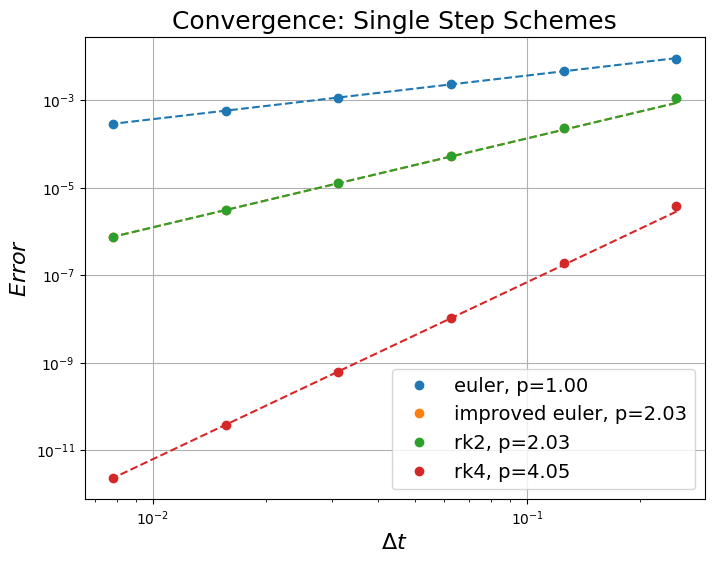

In [69]:
N = numpy.array([ 2**n for n in range(4,10)])
err_euler = numpy.zeros(len(N))
err_ieuler = numpy.zeros(len(N))
err_RK2 = numpy.zeros(len(N))
err_RK4 = numpy.zeros(len(N))

t_span = [ 0., 4.]
dt = t_span[1]/N

u0 = 1.
u_exact = u0*numpy.exp(-t_span[1])

for i, n in enumerate(N):
    t, u_euler = euler(f, t_span, u0, n)
    err_euler[i] = numpy.abs(u_euler[-1] - u_exact)
    t, u_ieuler = improved_euler(f, t_span, u0, n)
    err_ieuler[i] = numpy.abs(u_ieuler[-1] - u_exact)
    t, u_RK2 = RK2(f, t_span, u0, n)
    err_RK2[i] = numpy.abs(u_RK2[-1] - u_exact)
    t, u_RK4 = RK4(f, t_span, u0, n)
    err_RK4[i] = numpy.abs(u_RK4[-1] - u_exact)

err_fit = lambda dt, p: numpy.exp(p[1])*dt**p[0]
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

# Euler
p = numpy.polyfit(numpy.log(dt[2:]), numpy.log(err_euler[2:]),1)
line = axes.loglog(dt, err_euler, 'o', label='euler, p={:3.2f}'.format(p[0]))
axes.loglog(dt, err_fit(dt,p),'--', color=line[0].get_color())

# Improved Euler
p = numpy.polyfit(numpy.log(dt[2:]), numpy.log(err_ieuler[2:]),1)
line = axes.loglog(dt, err_ieuler, 'o', label='improved euler, p={:3.2f}'.format(p[0]))
axes.loglog(dt, err_fit(dt,p),'--', color=line[0].get_color())

# RK2
p = numpy.polyfit(numpy.log(dt[2:]), numpy.log(err_RK2[2:]),1)
line = axes.loglog(dt, err_RK2, 'o', label='rk2, p={:3.2f}'.format(p[0]))
axes.loglog(dt, err_fit(dt,p),'--', color=line[0].get_color())

#RK4
p = numpy.polyfit(numpy.log(dt[2:]), numpy.log(err_RK4[2:]),1)
line = axes.loglog(dt, err_RK4, 'o', label='rk4, p={:3.2f}'.format(p[0]))
axes.loglog(dt, err_fit(dt,p),'--', color=line[0].get_color())


axes.grid()
axes.set_xlabel('$\Delta t$', fontsize=16)
axes.set_ylabel('$Error$', fontsize=16)
axes.set_title('Convergence: Single Step Schemes', fontsize=18)
axes.legend(loc='best', fontsize=14)
plt.show()

## General Explicit Runge-Kutta Schemes and ``Butcher Tableaus''


The most general form of an explicit RK scheme with $s$ stages is

$$
    u_{n+1} = u_n +  \sum_{i=1}^s b_i K_{i}
$$

where

$$
K_{i} = \Delta t f\left(t_n + c_i \Delta t, u_n + \sum_{j=1}^{i-1} a_{ij} K_{j}\right)
$$

$K_{i}$ are the function evaluations at stage $i$ which are determined by coefficients $a_{ij}$, $b_i$ and $c_i$.  

All of the critical coefficients for any explicit RK scheme can be arranged in a ``Butcher tableau''

$$\begin{array} {c|ccccc} 0 & 0\\ c_2 & a_{21}\\ c_3 & a_{31} & a_{32} \\ \vdots & \vdots & & \ddots \\ c_s& a_{s1}& a_{s2} & \cdots & a_{s,s-1}\\ \hline & b_1 & b_2 & \cdots & b_{s-1} & b_s \end{array}
$$

where $c_i$ gives the fraction of the time step for each stage.  $b_i$ gives the weighting for each function evaluation $K_i$ in the general quadrature and the $a_{ij}$ determine how to use previous stages to advance the value of $u$ at stage $i$.

$$
K_{i} = \Delta t f\left(t_n + c_i \Delta t, u_n + \sum_{j=1}^{i-1} a_{ij} K_{j}\right)
$$

for more information see [here](https://www.johndcook.com/blog/2020/02/13/runge-kutta-methods/#:~:text=For%20explicit%20Runge%2DKutta%20methods,Butcher%20who%20classified%20RK%20methods)

All of the schemes we have discussed can be written as Butcher Tableaus (although they can be a bit hard to parse).  But for example:

#### Euler's method

$$
\begin{array} {c|c} 0 & 0\\ \hline & 1\end{array}
$$

#### Backwards Euler's method

$$
\begin{array} {c|c} 1 & 1\\ \hline & 1\end{array}
$$

#### Classical RK4

$$
\begin{array} {c|cccc} 0\\ 1/2 & 1/2\\ 1/2 &0 &1/2 \\ 1& 0& 0& 1\\ \hline & 1/6 & 1/3 & 1/3 &1/6 \end{array}
$$

Wikipedia provides a convenient [list](https://en.wikipedia.org/wiki/List_of_Runge%E2%80%93Kutta_methods)  of a large range of explicit and implicit RK schemes

## Adaptive Time Stepping

#### Why should we care about all of these schemes and their errors?

* Even though we know the formal error.  It is with respect to a true solution we don't know.
* In itself, the error estimates don't tell us how to choose a time step $\Delta t$ to keep the solution within a given tolerance
* However,  in combination, we can use multiple methods to control the error and provide **Adaptive** time stepping

#### Example:  Compare 1 step of Euler to one step of RK2


<>:43: SyntaxWarning: invalid escape sequence '\D'
<>:43: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-3002887803.py:43: SyntaxWarning: invalid escape sequence '\D'
  axes.text(dt+40, 0.5*(U1 + U0+K1), '$\Delta\propto\Delta t^2$', fontsize=18)


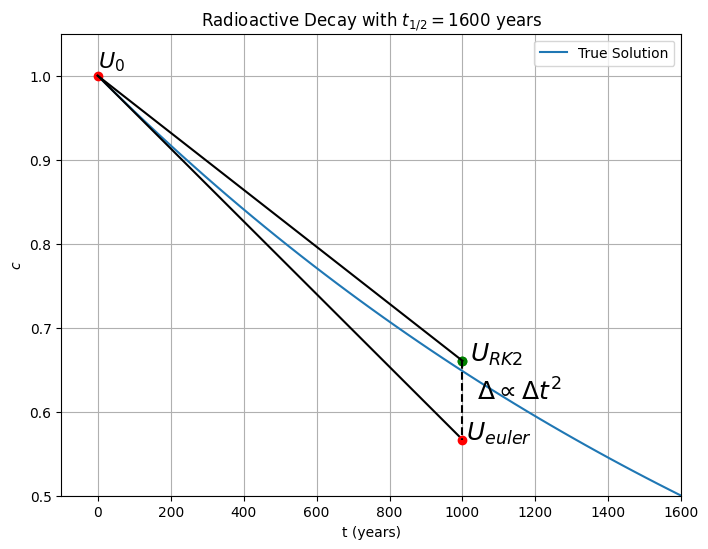

In [70]:
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

# RK2 step
dt = 1e3
U0 = 1.0
K1 = dt * f(0., U0)
Y1 = U0 + K1/2
K2 = dt * f(dt/2., Y1)
U1 = U0 + K2

t = numpy.linspace(U0, 1600.)
u_true = U0 * numpy.exp(decay_constant * t)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, u_true, label="True Solution")
axes.plot(0., U0, 'ro')
axes.text(0., U0+.01, '$U_0$', fontsize=16)
axes.plot((0.0, dt), (U0, U0 + K1), 'k')
#axes.plot((0.0, dt/2.), (U0, U0 + K1/2.), 'k')

#Euler step
axes.plot(dt, U0 + K1, 'ro')
#axes.plot((0.0, 0.0), (U0, Y1), 'k--')
axes.text(dt + 10., U0 + K1, '$U_{euler}$', fontsize=18)

axes.plot(dt, U1, 'go')
#axes.plot((0.0, 0.0), (U0, Y1), 'k--')
#axes.text(10., 0.85, '$\\frac{K_1}{2}$', fontsize=18)
#axes.plot((0.0, dt/2), (Y1, Y1), 'k--')
#axes.text(250, Y1 - 0.05, '$\\frac{\Delta t}{2}$', fontsize=18)

# RK2 Step
axes.plot(dt, U1, 'go')
axes.plot((0., dt), (U0, U1), 'k')
axes.text(dt+20, U1, '$U_{RK2}$', fontsize=18)
#axes.plot((0.0, 0.0), (U0, U1), 'g--')
#axes.plot((0.0, dt), (U1, U1), 'g--')

# difference
axes.plot((dt, dt), (U1, U0+K1),'k--')
axes.text(dt+40, 0.5*(U1 + U0+K1), '$\Delta\propto\Delta t^2$', fontsize=18)


axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.05))
axes.legend(loc='best')
axes.grid()
plt.show()

#### Relative Truncation Error

If we consider the *Step Error* for each of our schemes, we know that

$$
\begin{align}
    U^{euler}_{n+1}  &= u_{n+1} + O(\Delta t^2)\\
    U^{RK2}_{n+1} &= u_{n+1}  + O(\Delta t^3)\\
\end{align}
$$

Therefore we can compute the *relative truncation error* as

$$
    \Delta = | U^{euler}_{n+1} - U^{RK2}_{n+1} | = O(\Delta t^{?})
$$

* $\Delta$ is Computable!
* has a known dependence on step-size $\Delta t$

### Adaptive Time Stepping

Given the relative truncation error and its scaling with $\Delta t$, we can now use this to choose a single good time step.

#### Example:

Suppose we wanted our relative truncation error to be small relative to the solution or zero, we could set

$$
    \Delta_{target} = \mathtt{rtol}\,U^{RK2}_{n+1} + \mathtt{atol}
$$

where $\mathtt{rtol}$ and $\mathtt{atol}$ are relative and absolute tolerances (and we assume that $U^{RK2}_{n+1}$ is a reasonably good estimate of the true solution)

Moreover,  we know how the relative truncation error should scale with time step, i.e.

$$
    \Delta_{target} \propto \Delta t_{target}^2
$$


But our measured relative truncation error, $\Delta$ depends on  the step size we just took i.e

$$
    \Delta_{measured} \propto \Delta t_n^2
$$

### Adaptive Time Stepping

If we take the ratio of both relationships we get

$$
    \frac{\Delta_{target}}{\Delta_{measured}} = \left[\frac{\Delta t_{target}}{\Delta t_{n}}\right]^2
$$

or rearranging, we can solve for the target step size

$$
    \Delta t_{target} = \Delta t_{n}\left[\frac{\Delta_{target}}{\Delta_{measured}}\right]^{\frac{1}{2}}
$$

which tells us how to grow or shrink our time step to maintain accuracy.

In general,  if we have two methods with different step errors such that

$$
    \Delta \propto \Delta t^p
$$

then our adaptive stepper will look like

$$
    \Delta t_{target} = \Delta t_{n}\left[\frac{\Delta_{target}}{\Delta_{measured}}\right]^{1/p}
$$

This leads to all sorts of adaptive schemes most are included in standard libraries.  

### Embedded Runge-Kutta Schemes

There are in fact a whole family of **Embedded RK** schemes which are $N$ stage schemes but can combine the $N$ function evaluations in two different ways to produce methods with different error estimates.  

A popular one is **RK45** (available in `SciPy`) which is based on the [Dormand-Prince 5(4)](https://doi.org/10.1016/0771-050X(80)90013-3) pair which uses 6 function evaluations per step to produce a 4th order and 5th order scheme.  The 4th order scheme controls the time step, and the 5th order scheme actually is the solution.

#### Dormand-Prince 5(4) Butcher Tableau

$$
\begin{array} {c|ccccccc}
0\\
1/5 & 1/5\\
3/10 &3/40 & 9/40 \\
4/5 & 44/45& & −56/15	&32/9\\
8/9	& 19372/6561	& −25360/2187	& 64448/6561 &	−212/729\\
1 & 9017/3168 &	−355/33	& 46732/5247 & 49/176& −5103/18656 \\
1 & 35/384 & 0	& 500/1113	& 125/192	&−2187/6784	& 11/84	\\ \hline
& 35/384 &	0	& 500/1113 &	125/192 &	−2187/6784& 	11/84	&0\\
& 5179/57600 &	0	& 7571/16695	& 393/640	& −92097/339200	& 187/2100	& 1/40\\
\end{array}
$$


The first row of $b$ coefficients gives the fifth-order accurate solution and the second row gives the fourth-order accurate solution.

In [89]:
from scipy.integrate import solve_ivp

def f_vanderpol(t, u, mu=5):
    return numpy.array([u[1], mu * (1.0 - u[0]**2) * u[1] - u[0]])

t_span = (0., 50.)
u0 = [ 1., 0. ]
f = lambda t, u : f_vanderpol(t, u, mu=20)
#sol = solve_ivp(f, t_span, u0, method='RK45',rtol=1.e-3,atol=1.e-8)
sol = solve_ivp(f, t_span, u0, method='BDF',rtol=1.e-3,atol=1.e-8)

<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1544735939.py:15: SyntaxWarning: invalid escape sequence '\D'
  axes.set_ylabel('$\Delta t$', fontsize=16)


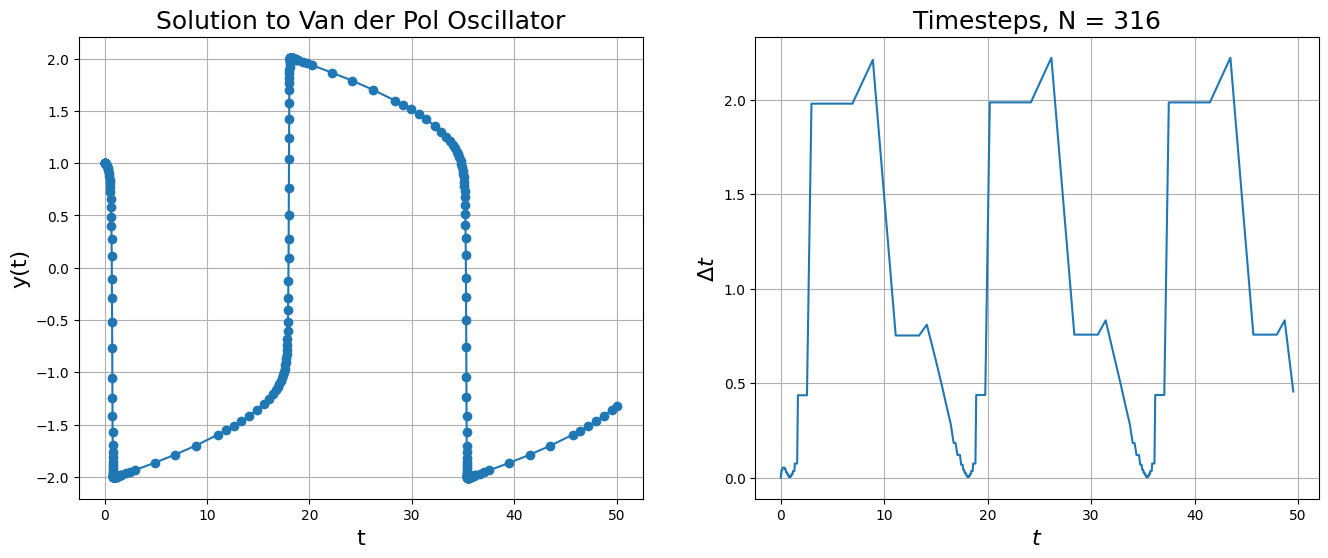

In [90]:
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)

axes.plot(sol.t, sol.y[0],'o-')
axes.set_title("Solution to Van der Pol Oscillator", fontsize=18)
axes.set_xlabel("t", fontsize=16)
axes.set_ylabel("y(t)", fontsize=16)
axes.grid()

axes = fig.add_subplot(1, 2, 2)
delta_t = sol.t[1:] - sol.t[:-1]
axes.plot(sol.t[:-1], delta_t)
axes.grid()
axes.set_xlabel('$t$', fontsize=16)
axes.set_ylabel('$\Delta t$', fontsize=16)
axes.set_title('Timesteps, N = {}'.format(len(sol.t)), fontsize=18)

plt.show()

## Taylor Series Methods

A **Taylor series method** can be derived by direct substitution of the right-hand-side function $f(t, u)$ and its appropriate derivatives into the Taylor series expansion for $u(t_{n+1})$.  For a $p$th order method we would look at the Taylor series up to that order and replace all the derivatives of $u$ with derivatives of $f$ instead.  

For the general case we have
$$\begin{align*}
    u(t_{n+1}) = u(t_n) + \Delta t u'(t_n) + \frac{\Delta t^2}{2} u''(t_n) + \frac{\Delta t^3}{6} u'''(t_n) + \cdots + \frac{\Delta t^p}{p!} u^{(p)}(t_n)
\end{align*}$$
which contains derivatives of $u$ up to $p$th order.  

We then replace these derivatives with the appropriate derivative of $f$ which will always be one less than the derivative of $u$ (due to the original ODE)

$$
    u^{(p)}(t_n) = f^{(p-1)}(t_n, u(t_n))
$$

leading to the method

$$
\begin{align}
    u(t_{n+1}) &= u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{\Delta t^2}{2} f'(t_n, u(t_n)) \\
    &+ \frac{\Delta t^3}{6} f''(t_n, u(t_n)) + \cdots + \frac{\Delta t^p}{p!} f^{(p-1)}(t_n, u(t_n)).
\end{align}
$$

### 2nd Order Taylor Series Method

We want terms up to second order so we need to take the derivative of $u' = f(t, u)$ once to find $u'' = f'(t, u)$ and therefore
$$\begin{align*}
    u(t_{n+1}) &= u(t_n) + \Delta t u'(t_n) + \frac{\Delta t^2}{2} u''(t_n) \\
    &=u(t_n) + \Delta t f(t_n, u(t_n)) + \frac{\Delta t^2}{2} f'(t_n, u(t_n)) ~~~ \text{or} \\
    U_{n+1} &= U_n + \Delta t f(t_n, U_n) + \frac{\Delta t^2}{2} f'(t_n, U_n).
\end{align*}$$

With Step error $O(\Delta t^3)$ and truncation error $T$, $O(\Delta t^2)$

### Example

Let's use our simplest problem $u'(t) = \lambda u$ with $f=\lambda u$.  Therefore

$$\begin{align*}
    f(t,u) &= \lambda u\\
    f'(t,u) &= \lambda u' = \lambda f = \lambda^2 u\\
    f''(t,u) &= \lambda^2 u' = \lambda^2 f = \lambda^3 u
\end{align*}$$

so a third order scheme would look like
$$
\begin{align}
    U(t_{n+1}) &= U(t_n)\left[ 1 + \lambda\Delta t  + \frac{(\lambda\Delta t)^2}{2} + \frac{(\lambda\Delta t)^3}{6}\right]+ O(\Delta t^4)
\end{align}
$$

In [73]:
def Taylor_3_flambda_u(lamda, t_span, u0, N):
    """ implement constant step size  3rd order Taylor Series method for f(t,u) = \lambda u"""

    t = numpy.linspace(t_span[0], t_span[1], N)
    lambda_dt = lamda*(t[1] - t[0])
    u = numpy.empty(t.shape)
    u[0] = u0
    for (n, t_n) in enumerate(t[:-1]):
        u[n+1] = u[n] * ( 1. + lambda_dt  + (lambda_dt**2)/2.  + (lambda_dt**3)/6.)
    return t, u


<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2231055704.py:2: SyntaxWarning: invalid escape sequence '\l'
  """ implement constant step size  3rd order Taylor Series method for f(t,u) = \lambda u"""


In [74]:
lam = -1.
t_span = [0., 5.]
u0 = 1.

f = lambda t,u : -u
t_exact = numpy.linspace(t_span[0], t_span[1], 100)
u_exact = u0*numpy.exp(-t_exact)

N = 20
t_taylor, u_taylor = Taylor_3_flambda_u(lam, t_span, u0, N)
t_euler, u_euler = euler(f, t_span, u0, N)

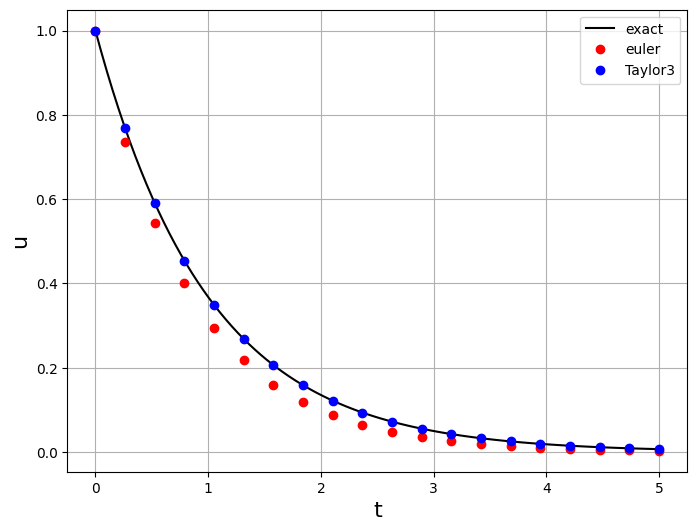

In [75]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_exact,u_exact,'k',label='exact')
axes.plot(t_euler, u_euler, 'ro', label='euler')
axes.plot(t_taylor, u_taylor, 'bo', label='Taylor3')

axes.grid()
axes.set_xlabel('t', fontsize=16)
axes.set_ylabel('u', fontsize=16)
axes.legend(loc='best')
plt.show()


### Some Drawbacks

**Taylor Series methods**
 - require differentiating the given equation which can be cumbersome and difficult to implement
 - require a new routine for every $f$

**General one-step/multi-stage methods**
  - higher order methods often require a large number of evaluations of $f$ per time step

# Overview -- so far

So far we have discussed 3 basic techniques for integration of ODE IVP's

* **Single-Step Multi-Stage** schemes (explicit and implicit)
* **Taylor's Series** Methods
* **Linear Multi-step** schemes (just started this)

as well as
* **truncation error** of each method (and its relation to step-error)
* **adaptive stepping** for Single-Step Schemes

In general Single-Step Multi-Stage methods (e.g. Embedded RK schemes) plus adaptive time stepping make for a very robust family of solvers. However there are some other classical schemes worth mentioning that have some advantages

## Linear Multi-Step Methods

**Multi-step methods**  are ODE methods that
 - require only *one* new function evaluation per time step  to work.  
 - reuse values and function evaluations at some number of previous time steps

**Disadvantages over single step methods**

 - Methods are not self-starting, i.e. they require other methods to find the initial values
 - Difficult to adapt. The time step  Δ𝑡  in one-step methods can be changed at any time while multi-step methods this is much more complex

### Simplest example:  The leap-frog method

The leap-frog method is similar to Euler's method in that it uses the information from two-previous time steps to advance the problem.  We can write the problem as a centered first-derivative centered   at time $t_{n+1}, U_{n+1}$ i.e.

$$\frac{U_{n+2} - U_{n}}{2\Delta t} = f(t_{n+1}, U_{n+1})$$

or

$$
    U_{n+2} = U_{n} + 2\Delta t\, f(t_{n+1}, U_{n+1})
$$

this method is known as the leap-frog method

<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-4060551557.py:17: SyntaxWarning: invalid escape sequence '\D'
  axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)


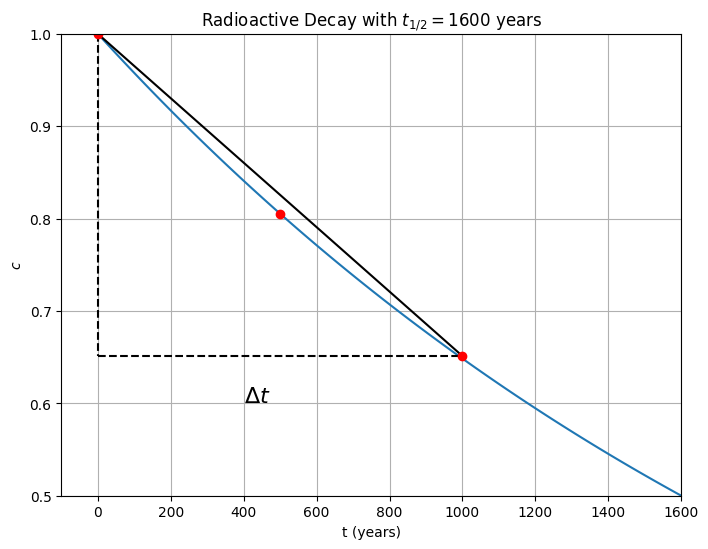

In [76]:
t = numpy.linspace(0.0, 1.6e3, 100)
c_0 = 1.0
decay_constant = -numpy.log(2.0) / 1600.0

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, c_0 * numpy.exp(decay_constant * t), label="True Solution")

# Plot Leap-Frog step
dt = 1e3
u1 = c_0 * numpy.exp(decay_constant * dt / 2.0)
u_np = c_0 + dt * (decay_constant * u1)
axes.plot((0.0, dt), (c_0, u_np), 'k')
axes.plot((dt, dt), (u_np, c_0 * numpy.exp(decay_constant * dt)), 'k--')
axes.plot((0.0, 0.0), (c_0, u_np), 'k--')
axes.plot((0.0, dt), (u_np, u_np), 'k--')
axes.text(400, u_np - 0.05, '$\Delta t$', fontsize=16)
axes.plot([0., dt/2, dt], [ c_0, u1, u_np],'ro')
axes.set_title("Radioactive Decay with $t_{1/2} = 1600$ years")
axes.set_xlabel('t (years)')
axes.set_ylabel('$c$')
axes.grid()
axes.set_xlim(-1e2, 1.6e3)
axes.set_ylim((0.5,1.0))
plt.show()

In [77]:
def leap_frog(f, t_span, u0, N, start=RK2):
    """ calculate fixed step with leap-frog iterator with a single step starter
    """
    t = numpy.linspace(t_span[0], t_span[1], N)
    delta_t = t[1] - t[0]
    u = numpy.zeros(t.shape)
    u[0] = u0
    # use a single-step multi-stage method to start

    t_start, u_start = start(f, (t[0],t[1]), u0, 2)
    u[1] = u_start[-1]
    for (n, t_np) in enumerate(t[1:-1]):
        u[n+2] = u[n] +  2 *delta_t * f(t_np, u[n+1])
    return t, u

In [78]:
u0 = 1.0
t_span = (0., 1600.)
N = 21

# Stable example
decay_constant = -numpy.log(2.0) / 1600.0
f = lambda t, u: decay_constant * u

t_exact = numpy.linspace(t_span[0], t_span[1], N)
u_exact = u0 * numpy.exp( decay_constant * t_exact)

t_leapfrog, u_leapfrog = leap_frog(f, t_span, u0, N, start=RK4)

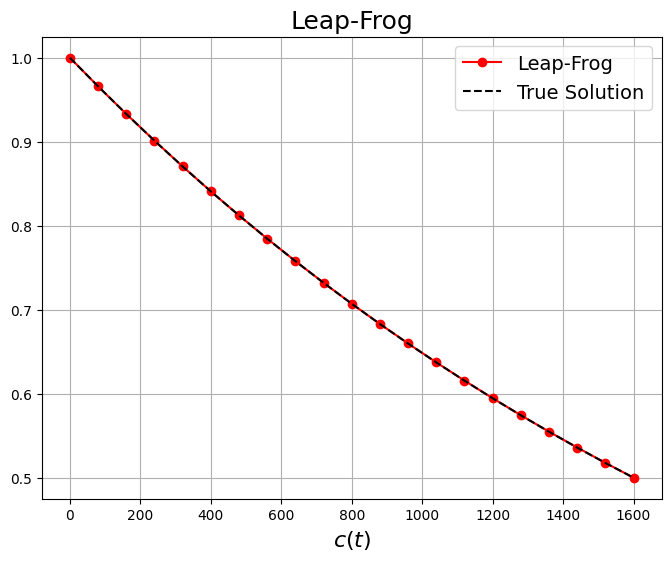

In [79]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t_leapfrog, u_leapfrog, 'or-', label="Leap-Frog")
axes.plot(t_exact, u_exact, 'k--', label="True Solution")
axes.grid()
axes.set_title("Leap-Frog", fontsize=18)
axes.set_xlabel("t (years)", fontsize=16)
axes.set_xlabel("$c(t)$", fontsize=16)
axes.legend(loc='best', fontsize=14)
plt.show()

### Error Analysis of Leap-Frog Method

To easily analyze this method we will expand the Taylor series around time $t_{n+1}$ to yield
$$\begin{aligned}
    u_{n+2} &= u_{n+1} + \Delta t f(t_{n+1},u_{n+1}) + \Delta t^2 \frac{u''(t_{n+1})}{2}  + \Delta t^3 \frac{u'''(t_{n+1})}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$$

We need one more expansion however due to leap-frog.  Recall that leap-frog has the form
$$
    U_{n+2} = U_{n} + 2 \Delta t f(t_{n+1}, U_{n+1}).
$$
To handle the $U_{n}$ term we need to write this with relation to $u(t_{n+1})$.  Again we use the Taylor series
$$
    u(t_n) = u_{n+1} - \Delta t f_{n+1} + \Delta t^2 \frac{u''(t_{n+1})}{2}  - \Delta t^3 \frac{u'''(t_{n+1})}{6} + \mathcal{O}(\Delta t^4)
$$

$$\begin{aligned}
    u(t_{n+2}) &= u_{n+1} + \Delta t f_{n+1} + \Delta t^2 \frac{u''(t_{n+1})}{2}  + \Delta t^3 \frac{u'''(t_{n+1})}{6} + \mathcal{O}(\Delta t^4)\\
    u(t_{n}) &= u_{n+1} - \Delta t f_{n+1} + \Delta t^2 \frac{u''(t_{n+1})}{2}  - \Delta t^3 \frac{u'''(t_{n+1})}{6} + \mathcal{O}(\Delta t^4)
\end{aligned}$$

Plugging these into our definition of the truncation error along with the leap-frog method definition leads to

$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} \left [\underbrace{U_{n} + 2 \Delta t f_{n+1}}_{U_{n+2}} - \underbrace{\left(u_{n+1} + \Delta t f_{n+1} + \Delta t^2 \frac{u''(t_{n+1})}{2}  + \Delta t^3 \frac{u'''(t_{n+1})}{6} + \mathcal{O}(\Delta t^4) \right )}_{u(t_{n+2})} \right ] \\
    &=\frac{1}{\Delta t} \left [ \underbrace{ \left(u_{n+1} - \Delta t f_{n+1} + \Delta t^2 \frac{u''(t_{n+1})}{2}  - \Delta t^3 \frac{u'''(t_{n+1})}{6} + \mathcal{O}(\Delta t^4)\right)}_{u_{n}} + 2\Delta t f_n - \underbrace{\left(u_{n+1} + \Delta t f_{n+1} + \Delta t^2 \frac{u''(t_{n+1})}{2}  + \Delta t^3 \frac{u'''(t_{n+1})}{6} + \mathcal{O}(\Delta t^4) \right )}_{u(t_{n+2})} \right ] \\
    &=\frac{1}{\Delta t} \left [- \Delta t^3 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^4) \right ] \\
        &=- \Delta t^2 \frac{u'''(t_n)}{3} + \mathcal{O}(\Delta t^3)
\end{aligned}$$

Therefore the method is second order accurate and is consistent theoretically.  In practice it's a bit more complicated than that.

In [80]:
# Compare accuracy between Euler, RK2 and Leap-Frog
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)
u_0 = 1.0

t_span = (0.0, 10.0)
num_steps = [2**n for n in range(4,11)]

<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-2222267416.py:35: SyntaxWarning: invalid escape sequence '\D'
  axes.set_xlabel("$\Delta t$",fontsize=16)


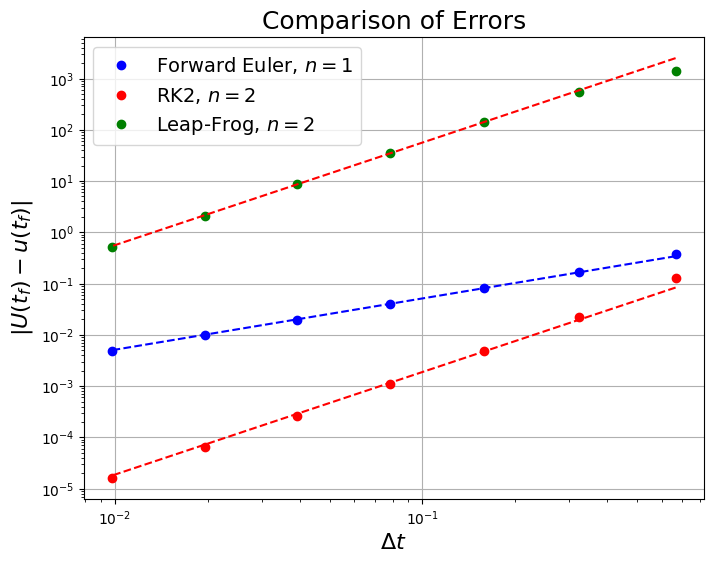

In [81]:
delta_t = numpy.empty(len(num_steps))
error_euler = numpy.empty(len(num_steps))
error_RK2 = numpy.empty(len(num_steps))
error_leapfrog = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(t_span[0], t_span[1], N)
    tt, u_euler = euler(f, t_span, u_0, N )
    tt, u_rk2 = RK2(f, t_span, u_0, N)
    tt, u_leapfrog = leap_frog(f, t_span, u_0, N, start=euler)

    delta_t[i] = t[1] - t[0]

    # Compute error for each
    error_euler[i] = numpy.linalg.norm(delta_t[i] * (u_euler - u_exact(t)), ord=1)
    error_RK2[i] = numpy.linalg.norm(delta_t[i] * (u_rk2 - u_exact(t)), ord=1)
    error_leapfrog[i] = numpy.linalg.norm(delta_t[i] * (u_leapfrog - u_exact(t)), ord=1)

# Plot error vs. delta_t
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))
axes.loglog(delta_t, error_euler, 'bo', label='Forward Euler, $n=1$')
axes.loglog(delta_t, error_RK2, 'ro', label='RK2, $n=2$')
axes.loglog(delta_t, error_leapfrog, 'go', label="Leap-Frog, $n=2$")

axes.loglog(delta_t, order_C(delta_t[2], error_euler[2], 1.0) * delta_t**1.0, '--b')
axes.loglog(delta_t, order_C(delta_t[2], error_RK2[2], 2.0) * delta_t**2.0, '--r')
axes.loglog(delta_t, order_C(delta_t[2], error_leapfrog[2], 2.0) * delta_t**2.0, '--r')

axes.grid()
axes.legend(loc=2, fontsize=14)
axes.set_title("Comparison of Errors", fontsize=18)
axes.set_xlabel("$\Delta t$",fontsize=16)
axes.set_ylabel("$|U(t_f) - u(t_f)|$", fontsize=16)

plt.show()

### Look at the errors for Leap-Frog

They're actually quite large...If you make a quick plot of u_leapfrog vs $t$ you'll see what's happening (and is a good example of an issue we will need to address in future lectures)

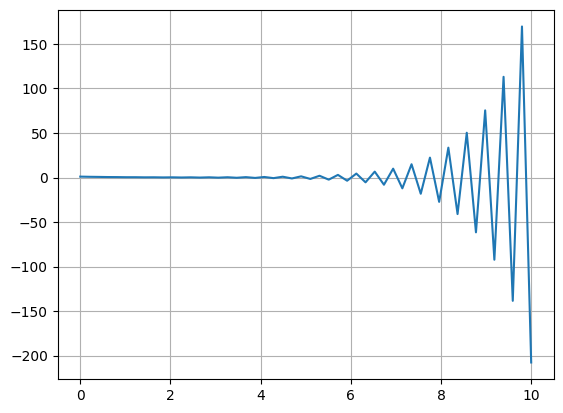

In [82]:
N= 50
t_leapfrog, u_leapfrog = leap_frog(f, t_span, u_0, N, start=euler)
## Your plotting code here
plt.figure()
plt.plot(t_leapfrog, u_leapfrog)
plt.grid()
plt.show()


### General Linear Multi-Step Methods

Leap-frog is perhaps the simplest of multi-step methods but all linear multi-step methods can be written as the linear combination of past, present and future solutions:
$$
    \sum^r_{j=0} \alpha_j U_{n+j} = \Delta t \sum^r_{j=0} \beta_j f(U_{n+j}, t_{n+j})
$$
If $\beta_r = 0$ then the method is explicit (only requires previous time steps).  Note that the coefficients are not unique as we can multiply both sides by a constant.  In practice a normalization of $\alpha_r = 1$ is used.

For example:  our Leap-frog method can be written using $r=2$, $\alpha = \begin{bmatrix} -1 & 0 & 1\\
\end{bmatrix}$, $\beta = \begin{bmatrix} 0 & 2 & 0 \\ \end{bmatrix}$

#### Example: Adams Methods

$$
    U_{n+r} = U_{n+r-1} + \Delta t \sum^r_{j=0} \beta_j f(U_{n+j}).
$$
All these methods have $\alpha_r = 1$, $\alpha_{r-1} = -1$ and $\alpha_j=0$ for $j < r - 1$.

### Adams-Bashforth Methods
The **Adams-Bashforth** methods are explicit solvers that maximize the order of accuracy given a number of steps $r$.  This is accomplished by looking at the Taylor series and picking the coefficients $\beta_j$ to eliminate as many terms in the Taylor series as possible.
$$\begin{aligned}
    \text{1-step:} & ~ & U_{n+1} &= U_n +\Delta t f(U_n) \\
    \text{2-step:} & ~ & U_{n+2} &= U_{n+1} + \frac{\Delta t}{2} (-f(U_n) + 3 f(U_{n+1})) \\
    \text{3-step:} & ~ & U_{n+3} &= U_{n+2} + \frac{\Delta t}{12} (5 f(U_n) - 16 f(U_{n+1}) + 23 f(U_{n+2})) \\
    \text{4-step:} & ~ & U_{n+4} &= U_{n+3} + \frac{\Delta t}{24} (-9 f(U_n) + 37 f(U_{n+1}) -59 f(U_{n+2}) + 55 f(U_{n+3}))
\end{aligned}$$

In [83]:
def AB2(f, t_span, u0, N, start=RK2):
    """ calculate fixed step Adams-Bashforth 2-step method with a single step starter
        reuses previous function evaluations
    """
    t = numpy.linspace(t_span[0], t_span[1], N)
    delta_t = t[1] - t[0]
    u = numpy.zeros(t.shape)

    u[0] = u0
    # use a single-step multi-stage method to start
    t_start, u_start = start(f, (t[0],t[1]), u0, 2)
    u[1] = u_start[-1]

    # set initial function evaluations
    fn = f(t[0], u[0])
    fnp = f(t[1], u[1])
    for (n, t_np) in enumerate(t[2:]):
        u[n+2] = u[n + 1] + delta_t / 2.0 * (-fn + 3.0 * fnp)
        fn = fnp
        fnp = f(t_np, u[n+2])
    return t, u

In [84]:
# Use 2-step Adams-Bashforth to compute solution
f = lambda t, u: -u
t_span = (0., 10.)
u0 = 1.0

N = 20
t, u_ab2 = AB2(f, t_span, u0, N, start=RK2)

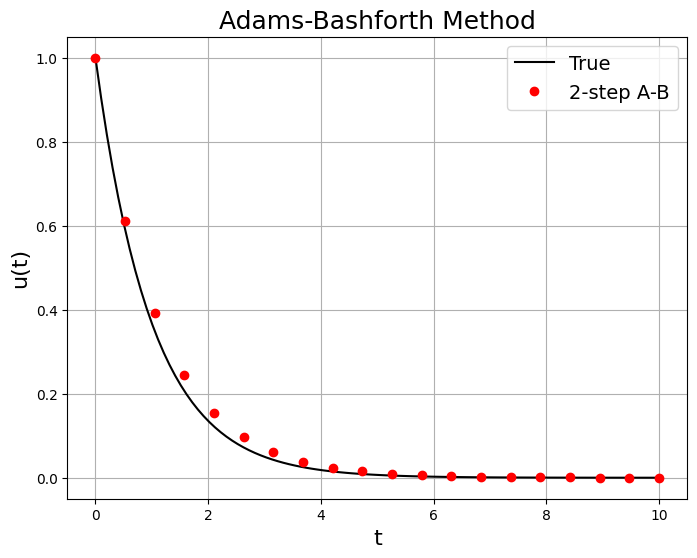

In [85]:
t_exact = numpy.linspace(t_span[0], t_span[1], 100)
u_exact = numpy.exp(-t_exact)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, u_ab2, 'ro', label="2-step A-B")

axes.set_title("Adams-Bashforth Method", fontsize=18)
axes.set_xlabel("t", fontsize=16)
axes.set_ylabel("u(t)",fontsize=16)
axes.legend(loc=1, fontsize=14)
axes.grid()

plt.show()

### Adams-Moulton Methods
The **Adams-Moulton** methods are the implicit versions of the Adams-Bashforth methods.  Since this gives one additional parameter to use $\beta_r$ these methods are generally one order of accuracy greater than their counterparts.
$$\begin{aligned}
    \text{1-step:} & ~ & U_{n+1} &= U_n + \frac{\Delta t}{2} (f(U_n) + f(U_{n+1})) \\
    \text{2-step:} & ~ & U_{n+2} &= U_{n+1} + \frac{\Delta t}{12} (-f(U_n) + 8f(U_{n+1}) + 5f(U_{n+2})) \\
    \text{3-step:} & ~ & U_{n+3} &= U_{n+2} + \frac{\Delta t}{24} (f(U_n) - 5f(U_{n+1}) + 19f(U_{n+2}) + 9f(U_{n+3})) \\
    \text{4-step:} & ~ & U_{n+4} &= U_{n+3} + \frac{\Delta t}{720}(-19 f(U_n) + 106 f(U_{n+1}) -264 f(U_{n+2}) + 646 f(U_{n+3}) + 251 f(U_{n+4}))
\end{aligned}$$

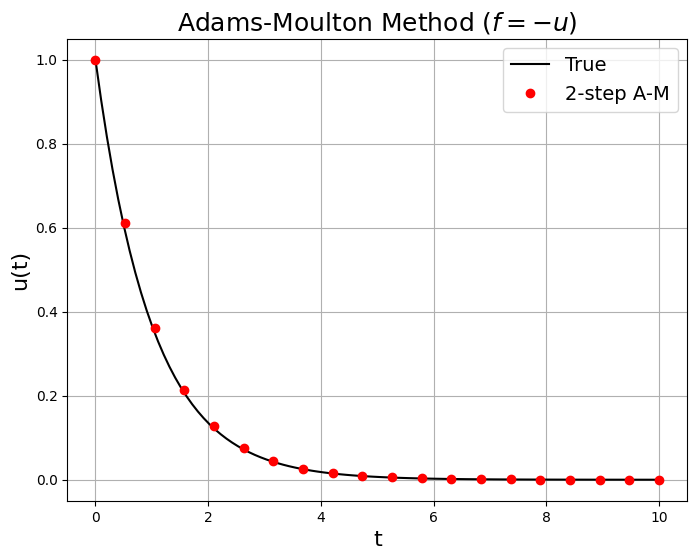

In [86]:
# Use 2-step Adams-Moulton to compute solution
# u' = - decay u
decay_constant = 1.0
f = lambda t, u: -decay_constant * u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 20
# N = 10
# N = 5
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)
U[0] = 1.0
U[1] = U[0] + 0.5 * delta_t * f(t[0], U[0])
U[1] = U[0] + delta_t * f(t[0], U[1])
integration_constant = 1.0 / (1.0 + 5.0 * decay_constant * delta_t / 12.0)
for n in range(t.shape[0] - 2):
    U[n+2] = (U[n+1] + decay_constant * delta_t / 12.0 * (U[n] - 8.0 * U[n+1])) * integration_constant

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, U, 'ro', label="2-step A-M")

axes.set_title("Adams-Moulton Method ($f=-u$)", fontsize=18)
axes.set_xlabel("t", fontsize=16)
axes.set_ylabel("u(t)", fontsize=16)
axes.legend(loc=1, fontsize=14)
axes.grid()
plt.show()

### Truncation Error for Multi-Step Methods

We can again find the truncation error in general for linear multi-step methods:
$$\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t} \left [\sum^r_{j=0} \alpha_j u_{n+j} - \Delta t \sum^r_{j=0} \beta_j f(u_{n+j}, t_{n+j}) \right ]
\end{aligned}$$

Using the general expansion and evaluation of the Taylor series about $t_n$ we have
$$\begin{aligned}
    u(t_{n+j}) &= u(t_n) + j \Delta t u'(t_n) + \frac{1}{2} (j \Delta t)^2 u''(t_n) + \mathcal{O}(\Delta t^3) \\
    u'(t_{n+j}) &= u'(t_n) + j \Delta t u''(t_n) + \frac{1}{2} (j \Delta t)^2 u'''(t_n) + \mathcal{O}(\Delta t^3)
\end{aligned}$$

collecting terms of order $u^{(p)}$

$$
\begin{aligned}
    T(t, u; \Delta t) &= \frac{1}{\Delta t}\left( \sum^r_{j=0} \alpha_j\right) u(t_n) + \left(\sum^r_{j=0} (j\alpha_j - \beta_j)\right) u'(t_n) + \Delta t \left(\sum^r_{j=0} \left (\frac{1}{2}j^2 \alpha_j - j \beta_j \right) \right) u''(t_n) \\
& \quad \quad + \cdots + \Delta t^{q - 1} \left (\sum^r_{j=0} \left(\frac{1}{q!} j^q \alpha_j - \frac{1}{(q-1)!} j^{q-1} \beta_j \right) \right) u^{(q)}(t_n) + \cdots
\end{aligned}$$

The method is *consistent* if the first two terms of the expansion vanish, i.e. $\sum^r_{j=0} \alpha_j = 0$ and $\sum^r_{j=0} j \alpha_j = \sum^r_{j=0} \beta_j$.

<>:63: SyntaxWarning: invalid escape sequence '\D'
<>:63: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-165722154.py:63: SyntaxWarning: invalid escape sequence '\D'
  axes.set_xlabel("$\Delta t$",fontsize=16)


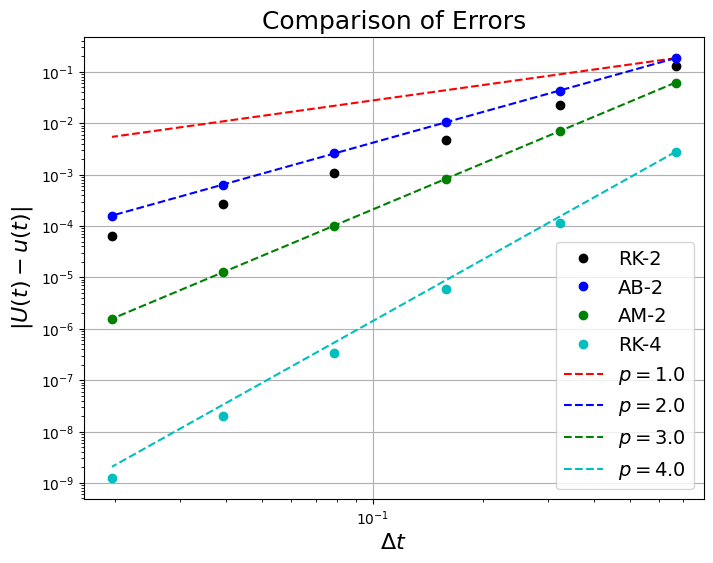

In [87]:
# Compare accuracy between RK-2, AB-2 and AM-2, RK-4
f = lambda t, u: -u
u_exact = lambda t: numpy.exp(-t)

t_f = 10.0
t_span = (0.0, t_f)

num_steps = [2**n for n in range(4,10)]
delta_t = numpy.empty(len(num_steps))
error_rk = numpy.empty(len(num_steps))
error_rk4 = numpy.empty(len(num_steps))
error_ab = numpy.empty(len(num_steps))
error_am = numpy.empty(len(num_steps))

for (i, N) in enumerate(num_steps):
    t = numpy.linspace(0, t_f, N)
    delta_t[i] = t[1] - t[0]

    # Compute RK2
    tt, U_rk  = RK2(f, t_span, u0, N)

    # Compute RK4
    tt, U_rk4  = RK4(f, t_span, u0, N)

    # Compute Adams-Bashforth 2-stage
    tt, U_ab  = AB2(f, t_span, u0, N)

    # Compute Adama-Moulton 2-stage
    U_am = numpy.empty(t.shape)
    U_am[:2] = U_rk[:2]
    decay_constant = 1.0
    integration_constant = 1.0 / (1.0 + 5.0 * decay_constant * delta_t[i] / 12.0)
    for n in range(t.shape[0] - 2):
        U_am[n+2] = (U_am[n+1] + decay_constant * delta_t[i] / 12.0 * (U_am[n] - 8.0 * U_am[n+1])) * integration_constant

    # Compute error for each
    error_rk[i] = numpy.linalg.norm(delta_t[i] * (U_rk - u_exact(t)), ord=1)
    error_rk4[i] = numpy.linalg.norm(delta_t[i] * (U_rk4 - u_exact(t)), ord=1)
    error_ab[i] = numpy.linalg.norm(delta_t[i] * (U_ab - u_exact(t)), ord=1)
    error_am[i] = numpy.linalg.norm(delta_t[i] * (U_am - u_exact(t)), ord=1)

# Plot error vs. delta_t
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.loglog(delta_t, error_rk, 'ko', label='RK-2')
axes.loglog(delta_t, error_ab, 'bo', label='AB-2')
axes.loglog(delta_t, error_am, 'go', label="AM-2")
axes.loglog(delta_t, error_rk4, 'co', label='RK-4')


order_C = lambda delta_x, error, order: numpy.exp(numpy.log(error) - order * numpy.log(delta_x))

colors = [ 'r', 'b', 'g', 'c']
start = [ error_ab[0], error_ab[0], error_am[0], error_rk4[0] ]
for i,c in enumerate(colors):
    order = i+1.
    axes.loglog(delta_t, order_C(delta_t[0], start[i], order) * delta_t**order, '--{}'.format(c),
                label='$p={}$'.format(order))

axes.legend(loc=4, fontsize=14)
axes.set_title("Comparison of Errors",fontsize=18)
axes.set_xlabel("$\Delta t$",fontsize=16)
axes.set_ylabel("$|U(t) - u(t)|$", fontsize=16)
axes.grid()

plt.show()

### Predictor-Corrector Methods

One way to simplify the Adams-Moulton methods so that implicit evaluations are not needed is by estimating the required implicit function evaluations with an explicit method.  These are often called **predictor-corrector** methods as the explicit method provides a *prediction* of what the solution might be and the now explicit *corrector* step works to make that estimate more accurate.

#### Example: One-Step Adams-Bashforth-Moulton

Use the One-step Adams-Bashforth method to predict the value of $U_{n+1}$ and then use the Adams-Moulton method to correct that value:
$$\begin{aligned}
    \hat{U}_{n+1} &= U_n + \Delta t f(U_n) \\
    U_{n+1} &= U_n + \frac{1}{2} \Delta t \left[f(U_n) + f(\hat{U}_{n+1}) \right]
\end{aligned}$$
leading to a second order accurate method.  Note this algorithm is identical to \_\_\_\_\_\_\_\_\_\_\_\__________?

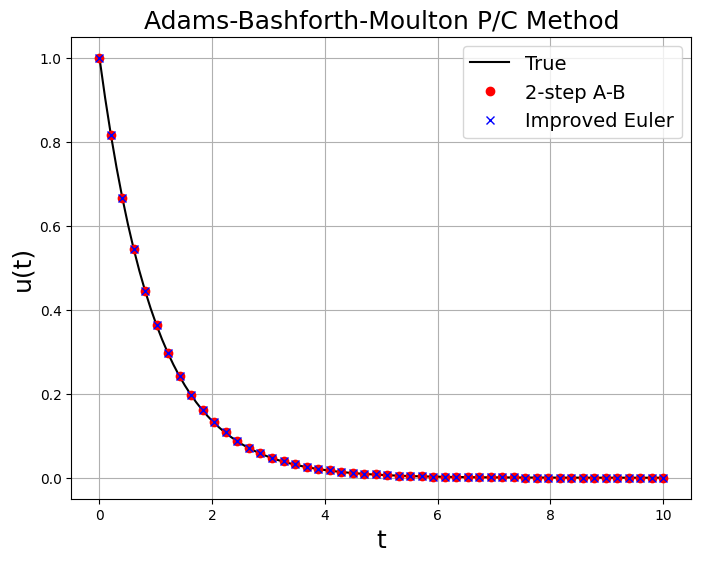

In [88]:
# One-step Adams-Bashforth-Moulton
f = lambda t, u: -u

t_exact = numpy.linspace(0.0, 10.0, 100)
u_exact = numpy.exp(-t_exact)

N = 50
t = numpy.linspace(0, 10.0, N)
delta_t = t[1] - t[0]
U = numpy.empty(t.shape)

U[0] = 1.0
for n in range(t.shape[0] - 1):
    U[n+1] = U[n] + delta_t * f(t[n], U[n])
    U[n+1] = U[n] + 0.5 * delta_t * (f(t[n], U[n]) + f(t[n+1], U[n+1]))

t_ie, u_ieuler = improved_euler(f, (0.0, 10.), 1., N)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)

axes.plot(t_exact, u_exact, 'k', label="True")
axes.plot(t, U, 'ro', label="2-step A-B")
axes.plot(t_ie, u_ieuler, 'bx', label="Improved Euler")


axes.set_title("Adams-Bashforth-Moulton P/C Method", fontsize=18)
axes.set_xlabel("t", fontsize=18)
axes.set_ylabel("u(t)", fontsize=18)
axes.legend(loc='best', fontsize=14)
axes.grid()

plt.show()